# Heart Rate Estimation
Seismocardiography ([SCG](https://www.ncbi.nlm.nih.gov/pubmed/24111357)) is a very promising technique to measure the Heart Rate (HR) and Respiratory Rate (RR) with a detector positioned above the sternum. It is generally based on accelerometer and gyroscope readings or a combination of them. 

Ballistocardiography ([BCG](https://en.wikipedia.org/wiki/Ballistocardiography)) is an another technique to estimate heart and respiratory rate with a combination of both an accelerometer and a gyroscope. It is an indirect evaluation of HR and RR since the contact between the device and the body of the subject is not required (e.g., the accelerometer platform can be mounted under the slats of the bed).   
  
MuSe (Multi-Sensor miniaturized, low-power, wireless [IMU](https://en.wikipedia.org/wiki/Inertial_measurement_unit)) is an Inertial Measurement Unit (IMU) provided by [221e](https://www.221e.com). In the context of this project, it allows to record the inertial data necessary for the estimation of SCG and BCG.

The goal of this assignment is to estimate the heart rate of an healthy subject, given the linear acceleration and angular velocity measurements recorded by using the aforementioned MuSe platform.

The study must be performed on two datasets: the first is the compulsory one (`center_sternum.txt`), while the second is left at the discretion of the group, among those made available for the assignment.

*Normal heart rate is around [40-100] bpm.*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
from matplotlib.pyplot import figure
from scipy import linalg as la
from scipy.spatial.transform import Rotation as R
import scipy.stats as stats
import math as m
from scipy.signal import argrelextrema
from tinyQuaternion import Quaternion
from datetime import datetime
from scipy import optimize
import scipy
import seaborn as sns

def random_color(): return plt.cm.viridis(np.random.rand())

## Data preparation

### Rough data:
Acc: linear acceleration vector  <br> 
Gyro: angular velocity vector  <br> 
Magn: magnetic field vector   <br> 
q: quaternions vector

In [2]:
data = pd.read_csv('center_sternum.txt', sep="\t")
data

Log Mode  Log Freq   Timestamp     AccX     AccY    AccZ      GyroX  \
0             5       200  1576222772  947.086  435.662  70.638  -6.824428   
1             5       200  1576222772  969.168  387.777  88.877   6.183206   
2             5       200  1576222772  989.603  380.335  78.751  11.709920   
3             5       200  1576222772  954.894  418.033  88.328  17.877860   
4             5       200  1576222772  972.096  427.732  99.857  25.221370   
...         ...       ...         ...      ...      ...     ...        ...   
16501         5       200  1576222847  958.493  291.092 -54.290   1.664122   
16502         5       200  1576222847  954.650  288.042 -49.654   1.480916   
16503         5       200  1576222847  967.338  290.482 -63.867   1.114504   
16504         5       200  1576222847  965.630  300.852 -56.242   0.702290   
16505         5       200  1576222847  959.957  298.473 -55.998   0.290076   

           GyroY     GyroZ  MagnX  MagnY  MagnZ        qw        qi        qj  \
0     -14.244280  1.404580   -454   -490   -178  0.792622  0.254952 -0.553850   
1     -12.290080 -7.969466   -454   -490   -177  0.736461  0.275124 -0.617969   
2      -4.961832 -7.450382   -454   -490   -177  0.729465  0.275246 -0.626118   
3       2.519084 -5.984733   -454   -492   -176  0.723413  0.277200 -0.632221   
4       5.404580  4.015267   -454   -492   -176  0.721948  0.280007 -0.632679   
...          ...       ...    ...    ...    ...       ...       ...       ...   
16501   2.305344 -0.671756   -494   -449   -126  0.650810  0.379162 -0.636402   
16502   2.488550 -0.702290   -494   -450   -125  0.650239  0.379803 -0.636708   
16503   3.374046 -0.900763   -494   -450   -125  0.649365  0.380627 -0.637227   
16504   3.664122 -1.587786   -495   -448   -124  0.648973  0.381329 -0.637348   
16505   4.061069 -1.343511   -495   -448   -124  0.648462  0.382336 -0.637471   

             qk  
0     -0.000031  
1      0.006806  
2      0.009827  
3      0.011383  
4      0.010193  
...         ...  
16501  0.166356  
16502  0.165960  
16503  0.165502  
16504  0.164953  
16505  0.164159  

[16506 rows x 16 columns]

### Calibration of the data 
$\vec{v_{cal}}= \bar{R} \cdot \vec{v_{in}}+ \vec{v_{offset}}$

In [3]:
R_gyro = np.identity(3)
off_gyro = np.array([-2.242224,2.963463,-0.718397])

R_acc = np.array([[1.000966, -0.002326418, -0.0006995499], [-0.002326379, 0.9787045, -0.001540918], [-0.0006995811, -0.001540928, 1.00403]])
off_acc = np.array([-3.929942,-13.74679, 60.67546])

R_mag = np.array([[0.9192851,-0.02325168,0.003480837],[-0.02325175,0.914876,0.004257396],[0.003481006,0.004257583,0.8748001]])
off_mag = np.array([-95.67974,-244.9142,17.71132])


def calibrate(title, R, off):
    xyz = ["X","Y","Z"]
    col=np.array([title+ ax for ax in xyz])
    d = np.array(data.loc[:,col])
    
    for i in range(len(d)):
        d[i] = R.dot(d[i]) + off

    for i in range(3):
        data[col[i]]=d[:,i]
    
    
calibrate("Gyro",R_gyro,off_gyro)
calibrate("Acc",R_acc,off_acc)
calibrate("Magn",R_mag,off_mag)

data


Log Mode  Log Freq   Timestamp        AccX        AccY        AccZ  \
0             5       200  1576222772  943.007996  410.325442  130.264244   
1             5       200  1576222772  965.209969  363.380701  148.635086   
2             5       200  1576222772  985.689106  356.065246  138.465450   
3             5       200  1576222772  950.852176  393.026437  148.047237   
4             5       200  1576222772  968.040164  402.461108  159.595720   
...         ...       ...         ...         ...         ...         ...   
16501         5       200  1576222847  954.849739  269.000099    5.047576   
16502         5       200  1576222847  951.006879  266.016847    9.709647   
16503         5       200  1576222847  963.711402  268.397270   -4.573267   
16504         5       200  1576222847  961.972293  278.538659    3.067677   
16505         5       200  1576222847  956.299177  276.223143    3.320295   

           GyroX      GyroY     GyroZ  MagnX  MagnY  MagnZ        qw  \
0      -9.066652 -11.280817  0.686183   -502   -683   -141  0.792622   
1       3.940982  -9.326617 -8.687863   -502   -683   -140  0.736461   
2       9.467696  -1.998369 -8.168779   -502   -683   -140  0.729465   
3      15.635636   5.482547 -6.703130   -502   -685   -139  0.723413   
4      22.979146   8.368043  3.296870   -502   -685   -139  0.721948   
...          ...        ...       ...    ...    ...    ...       ...   
16501  -0.578102   5.268807 -1.390153   -539   -644    -96  0.650810   
16502  -0.761308   5.452013 -1.420687   -539   -645    -95  0.650239   
16503  -1.127720   6.337509 -1.619160   -539   -645    -95  0.649365   
16504  -1.539934   6.627585 -2.306183   -540   -643    -94  0.648973   
16505  -1.952148   7.024532 -2.061908   -540   -643    -94  0.648462   

             qi        qj        qk  
0      0.254952 -0.553850 -0.000031  
1      0.275124 -0.617969  0.006806  
2      0.275246 -0.626118  0.009827  
3      0.277200 -0.632221  0.011383  
4      0.280007 -0.632679  0.010193  
...         ...       ...       ...  
16501  0.379162 -0.636402  0.166356  
16502  0.379803 -0.636708  0.165960  
16503  0.380627 -0.637227  0.165502  
16504  0.381329 -0.637348  0.164953  
16505  0.382336 -0.637471  0.164159  

[16506 rows x 16 columns]

### Columns selection

In [4]:
data = data[data.columns[2:]]
data

Timestamp        AccX        AccY        AccZ      GyroX      GyroY  \
0      1576222772  943.007996  410.325442  130.264244  -9.066652 -11.280817   
1      1576222772  965.209969  363.380701  148.635086   3.940982  -9.326617   
2      1576222772  985.689106  356.065246  138.465450   9.467696  -1.998369   
3      1576222772  950.852176  393.026437  148.047237  15.635636   5.482547   
4      1576222772  968.040164  402.461108  159.595720  22.979146   8.368043   
...           ...         ...         ...         ...        ...        ...   
16501  1576222847  954.849739  269.000099    5.047576  -0.578102   5.268807   
16502  1576222847  951.006879  266.016847    9.709647  -0.761308   5.452013   
16503  1576222847  963.711402  268.397270   -4.573267  -1.127720   6.337509   
16504  1576222847  961.972293  278.538659    3.067677  -1.539934   6.627585   
16505  1576222847  956.299177  276.223143    3.320295  -1.952148   7.024532   

          GyroZ  MagnX  MagnY  MagnZ        qw        qi        qj        qk  
0      0.686183   -502   -683   -141  0.792622  0.254952 -0.553850 -0.000031  
1     -8.687863   -502   -683   -140  0.736461  0.275124 -0.617969  0.006806  
2     -8.168779   -502   -683   -140  0.729465  0.275246 -0.626118  0.009827  
3     -6.703130   -502   -685   -139  0.723413  0.277200 -0.632221  0.011383  
4      3.296870   -502   -685   -139  0.721948  0.280007 -0.632679  0.010193  
...         ...    ...    ...    ...       ...       ...       ...       ...  
16501 -1.390153   -539   -644    -96  0.650810  0.379162 -0.636402  0.166356  
16502 -1.420687   -539   -645    -95  0.650239  0.379803 -0.636708  0.165960  
16503 -1.619160   -539   -645    -95  0.649365  0.380627 -0.637227  0.165502  
16504 -2.306183   -540   -643    -94  0.648973  0.381329 -0.637348  0.164953  
16505 -2.061908   -540   -643    -94  0.648462  0.382336 -0.637471  0.164159  

[16506 rows x 14 columns]

### Acquisition time and sampling frequency 
The nominal sampling frequency should be of $200 Hz$, so of 200 measurments for each second, but actually different numbers are found grouping by on the timestamp. 

In [5]:
t_min = datetime.fromtimestamp(data["Timestamp"].min())  #acquisition starting time
t_max = datetime.fromtimestamp(data["Timestamp"].max())  #acquisition ending time
acquisition_seconds = (t_max-t_min).total_seconds()      #total acquisition time
acq_per_sec = data.groupby("Timestamp").size()           #acquisitions per second
mean_sampling = np.mean(acq_per_sec)        #mean sampling 


print("Starting time: ", t_min)
print("Ending time: ", t_max)
print("Total time: ", acquisition_seconds, "s")

print("\nTotal number of acquisitions: ",data.shape[0])
print("Mean sampling frequency: ", mean_sampling)

Starting time:  2019-12-13 08:39:32
Ending time:  2019-12-13 08:40:47
Total time:  75.0 s

Total number of acquisitions:  16506
Mean sampling frequency:  217.18421052631578


### Sampling rate barplot

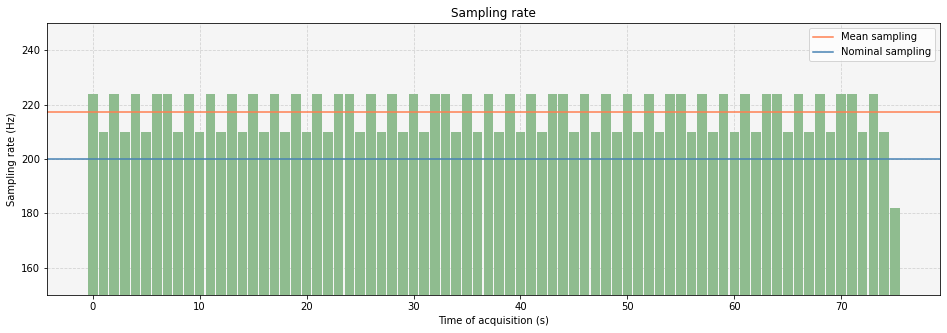

In [6]:
fig, ax= plt.subplots(figsize=(16, 5))
ax.bar(np.arange(0,len(acq_per_sec)), acq_per_sec, color ='darkseagreen', width = 0.9)
plt.title('Sampling rate')
plt.xlabel('Time of acquisition (s)')  
plt.ylabel('Sampling rate (Hz)')  
plt.ylim([150,250])
ax.axhline(y=mean_sampling, color='coral', linestyle='-', label='Mean sampling')
ax.axhline(y=200, color='steelblue', linestyle='-', label='Nominal sampling')
plt.legend(loc="upper right")
ax.set_facecolor('whitesmoke')
ax.set_axisbelow(True)
ax.grid(color='lightgray', linestyle='dashed')
plt.show()


### FIrst data plots

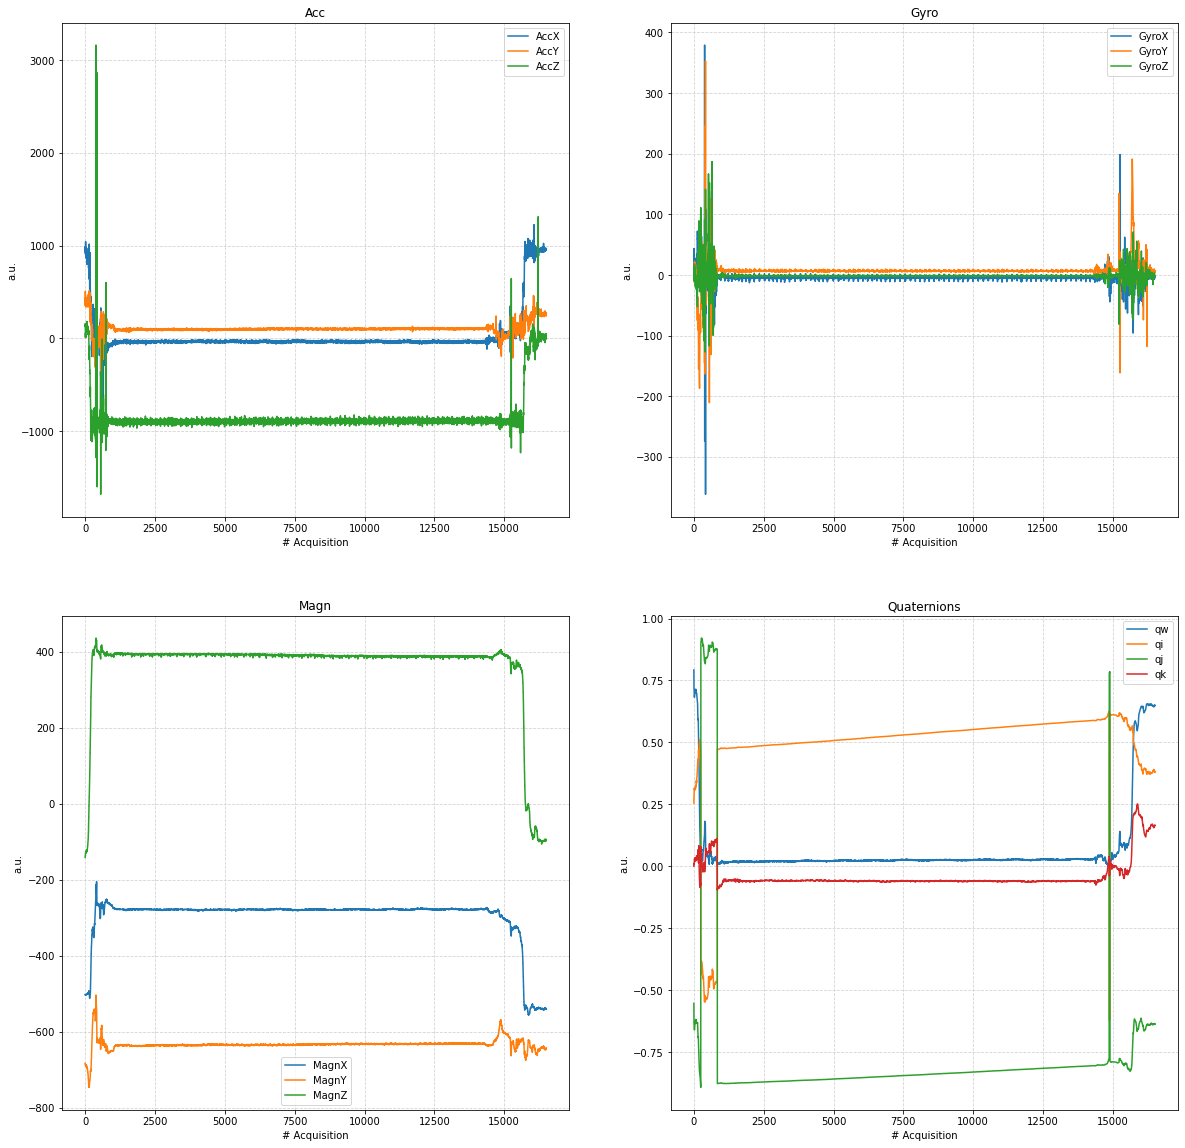

In [7]:
fig, ax = plt.subplots(ncols=2, nrows=2,figsize=(20, 20))

def plot_graph(title,a,b):
    if title=="Quaternions": 
        xyz = ["w","i","j","k"]
        t = "q"
        
    else: xyz = ["X","Y","Z"]; t = title
            
    columns=np.array([t+ ax for ax in xyz])

    
    for c,i in zip (columns, range(len(columns))):
        ax[a,b].plot(data[c], label=c)
        
    ax[a,b].set_title(title)
    ax[a,b].legend()
    ax[a,b].set_xlabel("# Acquisition")
    ax[a,b].set_ylabel("a.u.")
    ax[a,b].set_axisbelow(True)
    ax[a,b].grid(color='lightgray', linestyle='dashed')
    
plot_graph("Acc",0,0)
plot_graph("Gyro",0,1)
plot_graph("Magn",1,0)
plot_graph("Quaternions",1,1)

### Data selection
selection interval of $[2500:12500]$

In [6]:
data=data[2500:12500] #restrict the whole database between 2500 and 12500
data = data.reset_index(drop=True)

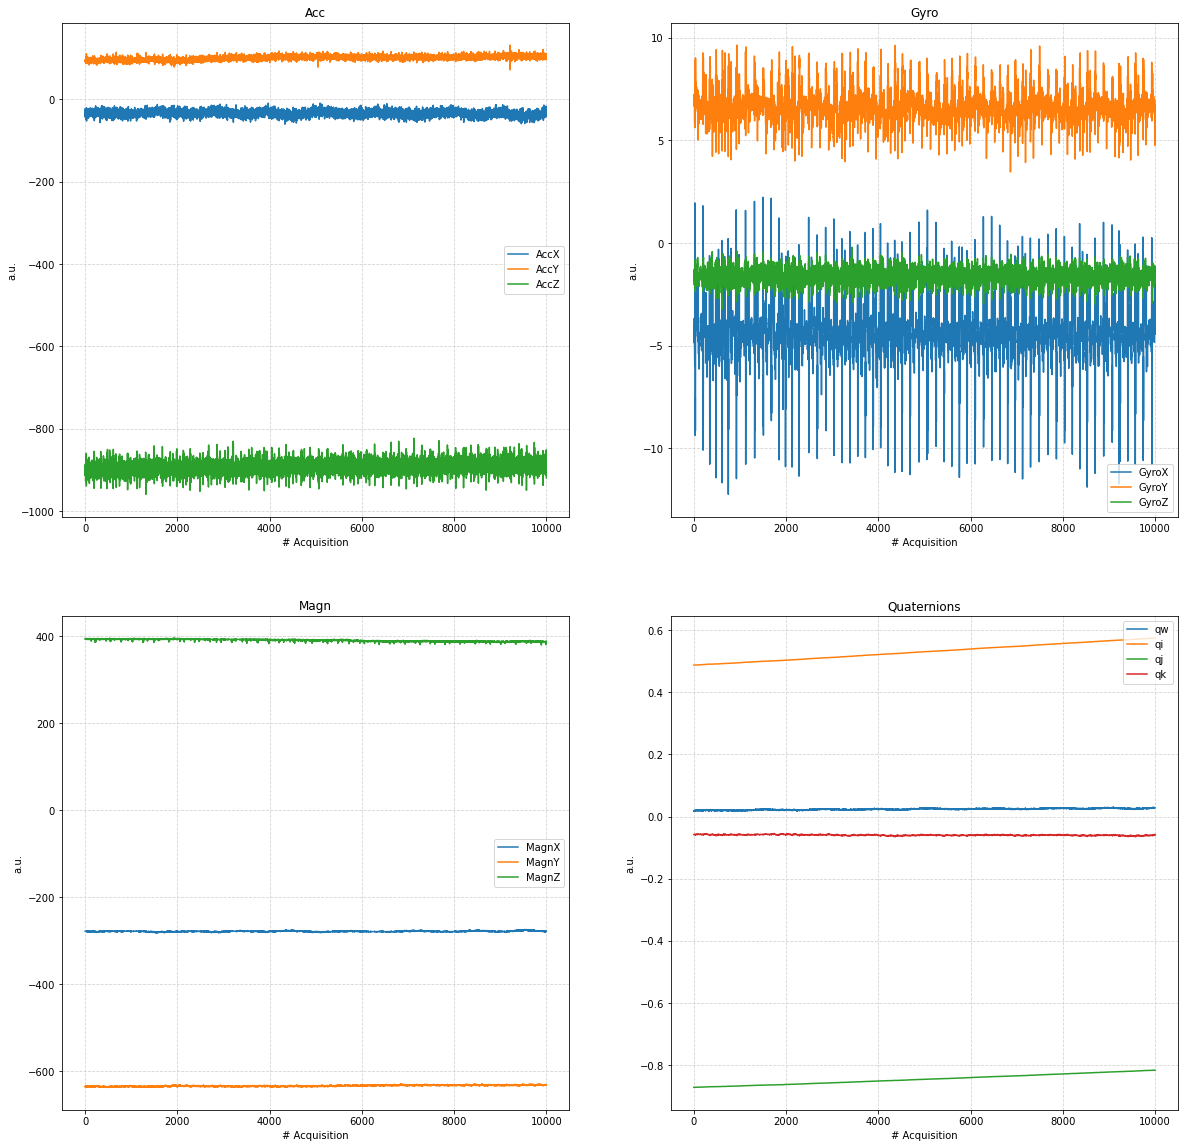

In [9]:
fig, ax = plt.subplots(ncols=2, nrows=2,figsize=(20, 20))
plot_graph("Acc",0,0)
plot_graph("Gyro",0,1)
plot_graph("Magn",1,0)
plot_graph("Quaternions",1,1)

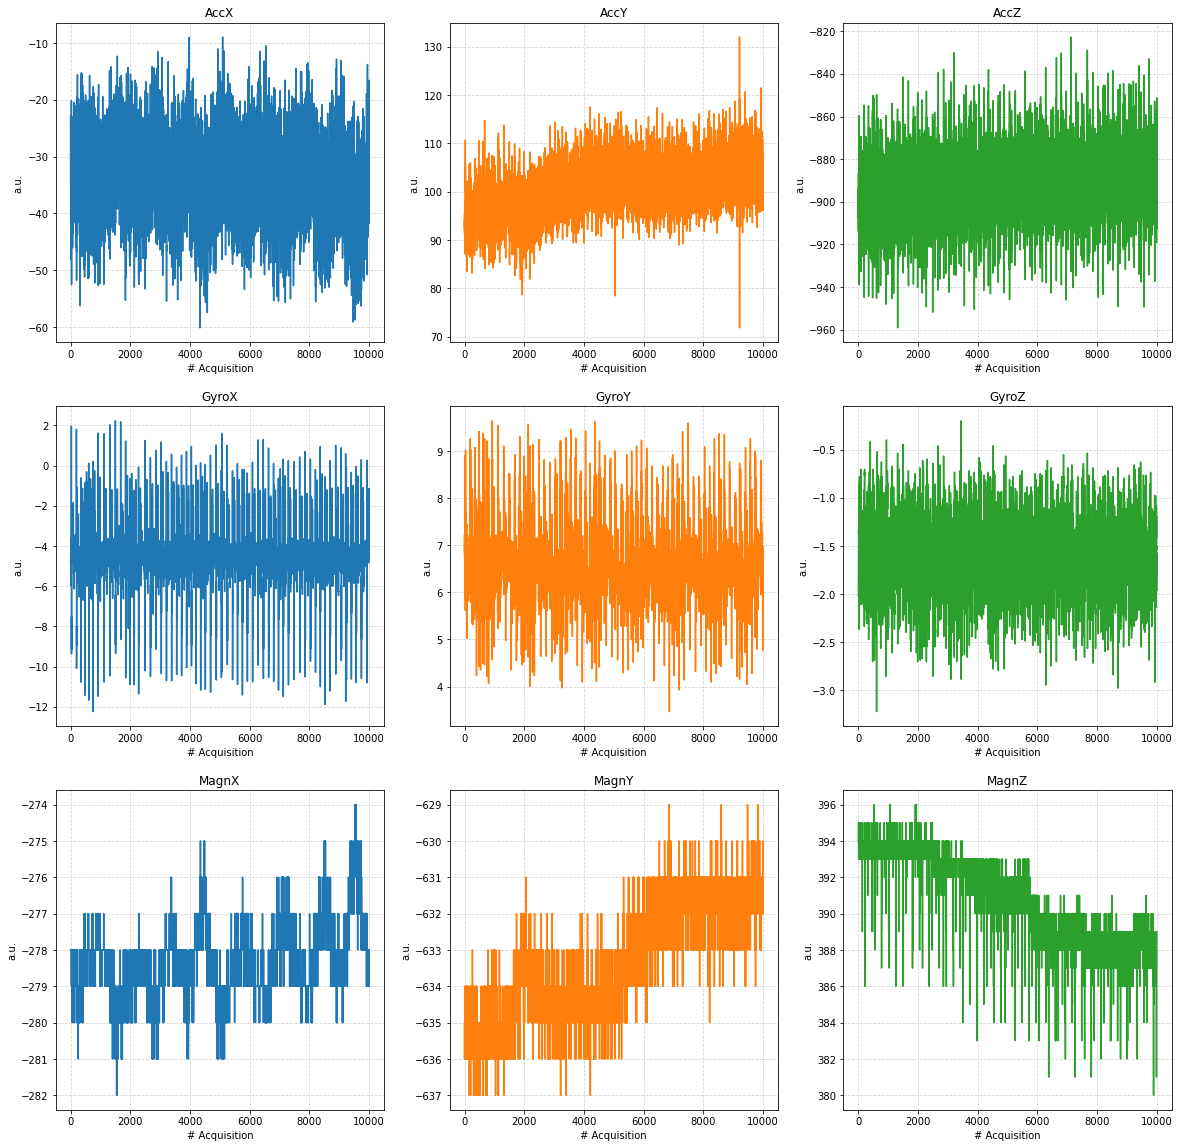

In [10]:
fig, ax = plt.subplots(ncols=3, nrows=3,figsize=(20,20))

def plot_graph(title,a):
    xyz = ["X","Y","Z"]
    colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
    for c in range(0,3):
        ax[a,c].plot(data.loc[:,title+xyz[c]], color=colors[c])
        ax[a,c].set_title(title+xyz[c])
        ax[a,c].set_xlabel("# Acquisition")
        ax[a,c].set_ylabel("a.u.")
        ax[a,c].set_axisbelow(True)
        ax[a,c].grid(color='lightgray', linestyle='dashed')
    
plot_graph("Acc",0)
plot_graph("Gyro",1)
plot_graph("Magn",2)

### Axis projections

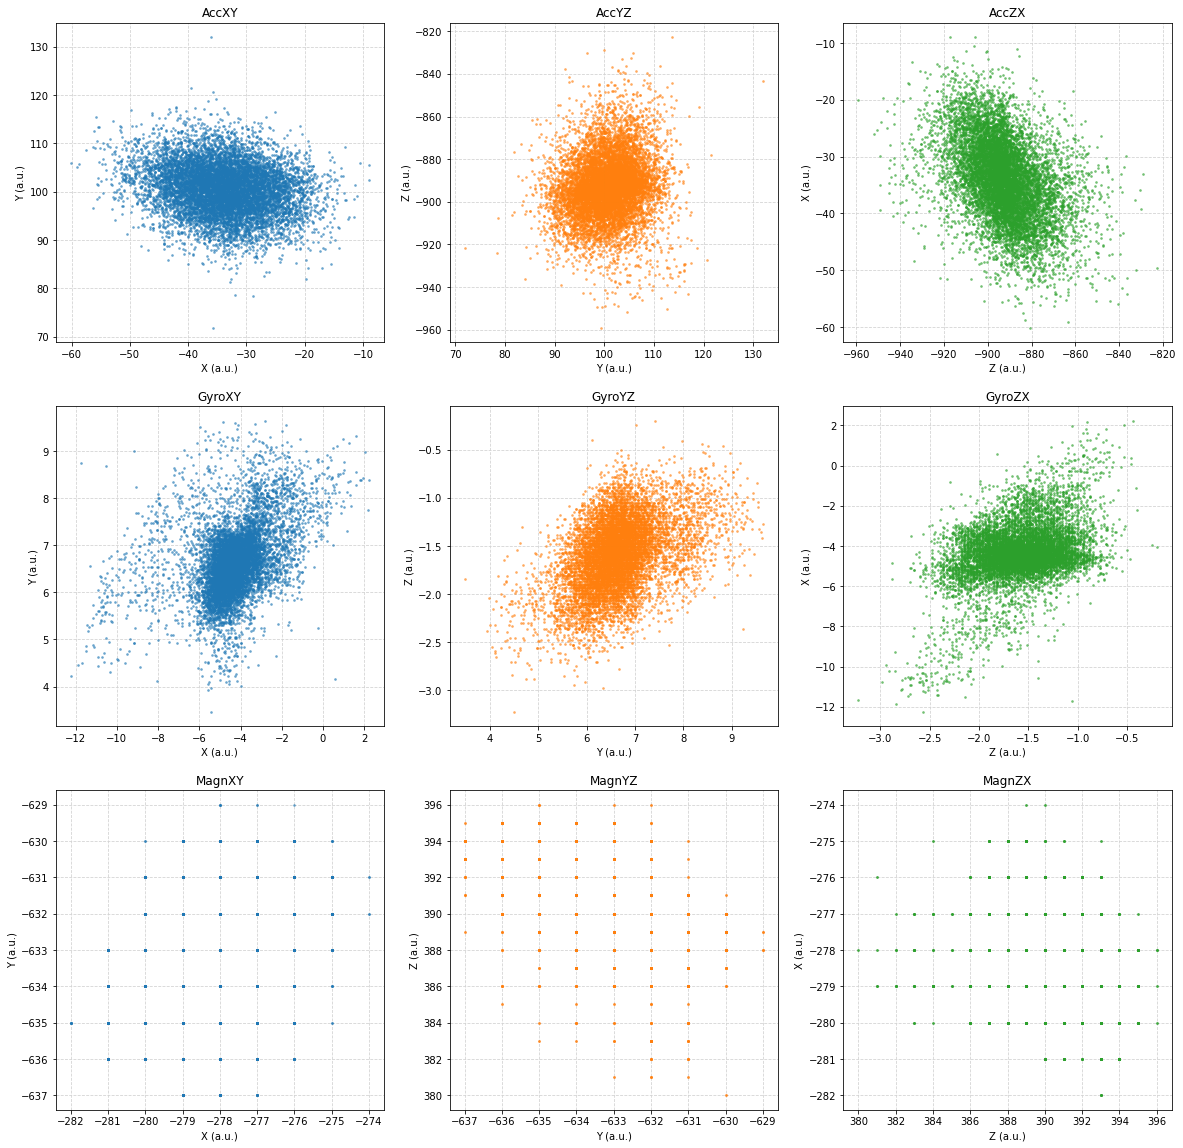

In [11]:
fig, ax = plt.subplots(ncols=3, nrows=3,figsize=(20, 20))

def plot_graph(title,a):
    xyz1 = ["X","Y","Z"]
    xyz2 = ["Y","Z","X"]
    colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
    for c in range(0,3):
        ax[a,c].scatter(data[title+xyz1[c]],data[title+xyz2[c]], color=colors[c], alpha=0.5, s=3)
        ax[a,c].set_title(title+xyz1[c]+xyz2[c])
        ax[a,c].set_xlabel(xyz1[c]+" (a.u.)")
        ax[a,c].set_ylabel(xyz2[c]+" (a.u.)")
        ax[a,c].set_axisbelow(True)
        ax[a,c].grid(color='lightgray', linestyle='dashed')
    
plot_graph("Acc",0)
plot_graph("Gyro",1)
plot_graph("Magn",2)

### Data zoom in ($\sim$2 seconds)

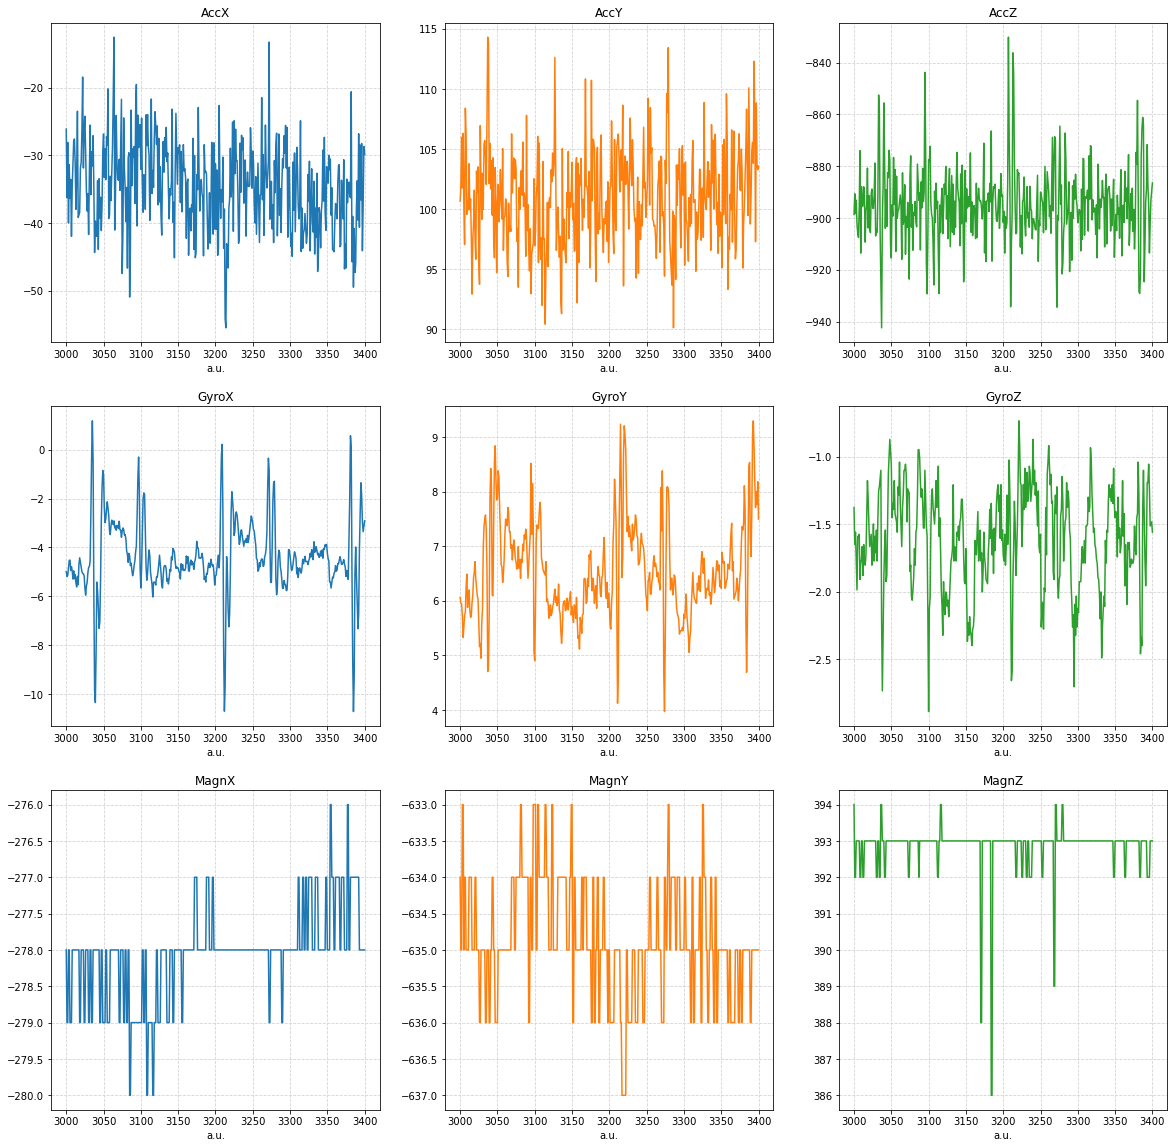

In [12]:
fig, ax = plt.subplots(ncols=3, nrows=3,figsize=(20, 20))

def plot_graph(title,a):
    xyz = ["X","Y","Z"]
    colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
    for c in range(0,3):
        ax[a,c].plot(data.loc[3000:3400,title+xyz[c]], color=colors[c])
        ax[a,c].set_title(title+xyz[c])
        ax[a,c].set_xlabel("# Acquisition")
        ax[a,c].set_xlabel("a.u.")
        ax[a,c].set_axisbelow(True)
        ax[a,c].grid(color='lightgray', linestyle='dashed')        
    
plot_graph("Acc",0)
plot_graph("Gyro",1)
plot_graph("Magn",2)

### Vectors modules 
$v=\left| \vec{v} \right|= \sqrt{v_{x}^{2}+v_{y}^{2}+v_{z}^{2}}$ <br>
$E_{rotational}=\frac{1}{2}I\omega ^{2}\; \; \; \; E_{traslational}=\frac{1}{2}m (a\Delta t) ^{2}$

In [7]:
def compute_module(title):
    xyz = ["X","Y","Z"]
    columns=np.array([title+ ax for ax in xyz])
    module = np.sqrt(np.square(data.loc[:,columns]).sum(axis=1))
    return module

columns = ["Acc","Gyro","Magn"]
modules_values = np.array(list(map(compute_module,columns)))
modules = pd.DataFrame(modules_values.T, columns=columns)
data=data.join(modules)
modules

Acc      Gyro        Magn
0     892.259256  8.616780  797.336190
1     912.900020  8.902085  797.336190
2     899.598697  8.670017  798.132821
3     903.802930  8.245406  797.336190
4     900.160375  8.111157  797.336190
...          ...       ...         ...
9995  875.903584  6.760187  790.259451
9996  873.597332  6.611690  791.546587
9997  859.300533  6.625875  791.546587
9998  867.334929  6.338835  791.685544
9999  926.529635  7.240620  791.685544

[10000 rows x 3 columns]

### Vectors modules ($\sim$5 seconds)

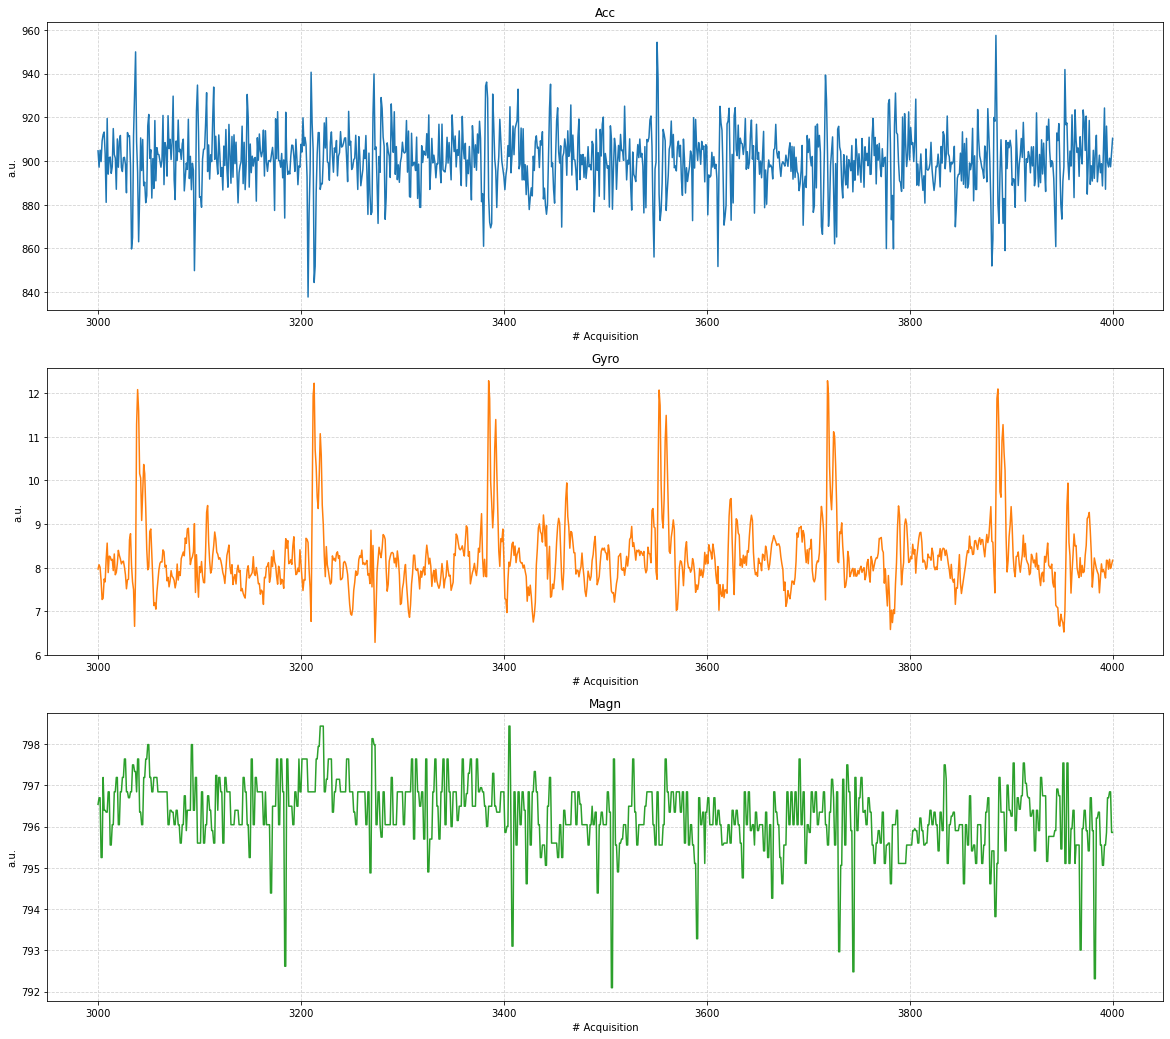

In [14]:
fig, ax = plt.subplots(nrows=3,figsize=(20, 18))

def plot_graph(title,a):
    colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
    ax[a].plot(modules.loc[3000:4000,title], color=colors[a])
    ax[a].set_title(title)
    ax[a].set_xlabel("# Acquisition")
    ax[a].set_ylabel("a.u.")
    ax[a].set_axisbelow(True)
    ax[a].grid(color='lightgray', linestyle='dashed')    
    
plot_graph("Acc",0)
plot_graph("Gyro",1)
plot_graph("Magn",2)

### Quaternions to angular coordinates
(TinyQuaternion package)

In [8]:
vec_in = np.array([1,0,0])  #chosen initial position: (1,0,0)

thetaX=np.zeros(len(data))
thetaY=np.zeros(len(data))
thetaZ=np.zeros(len(data))


for i in range(0,len(data)):
    q = Quaternion(a=data.iloc[i]['qw'], n=np.array([data.iloc[i]['qi'],data.iloc[i]['qj'],data.iloc[i]['qk']]))
    q=q.normalized
    vec=q.rotatePoint(vec_in)
    thetaX[i]=vec[0]
    thetaY[i]=vec[1]
    thetaZ[i]=vec[2]

data.loc[:,"thetaX"]=thetaX
data.loc[:,"thetaY"]=thetaY
data.loc[:,"thetaZ"]=thetaZ

data

Timestamp       AccX        AccY        AccZ     GyroX     GyroY  \
0     1576222783 -34.964327   92.555340 -886.756779 -4.791842  6.871860   
1     1576222783 -22.806330   95.603808 -907.593648 -4.852911  7.238272   
2     1576222783 -37.398683   91.378370 -894.163938 -4.746041  7.039799   
3     1576222783 -40.882782   94.078830 -897.962977 -4.410163  6.764990   
4     1576222783 -43.444481   91.870403 -894.405448 -4.150621  6.719188   
...          ...        ...         ...         ...       ...       ...   
9995  1576222829 -33.528075   99.749339 -869.559099 -4.455964  4.764990   
9996  1576222829 -27.611238  101.523031 -867.238717 -3.631537  5.253539   
9997  1576222829 -41.808383  110.068566 -851.195850 -2.364361  5.986364   
9998  1576222829 -40.208817  107.510800 -859.706088 -1.142987  6.016898   
9999  1576222829 -39.319880  110.644645 -919.058689 -2.120087  6.688654   

         GyroZ  MagnX  MagnY  MagnZ        qw        qi        qj        qk  \
0    -2.016107   -278   -635    394  0.017727  0.487075 -0.871242 -0.058138   
1    -1.817634   -278   -635    394  0.018413  0.487075 -0.871242 -0.057924   
2    -1.756565   -278   -636    394  0.018758  0.487106 -0.871212 -0.058016   
3    -1.664962   -278   -635    394  0.017649  0.487136 -0.871212 -0.058107   
4    -1.848168   -278   -635    394  0.018045  0.487136 -0.871212 -0.057985   
...        ...    ...    ...    ...       ...       ...       ...       ...   
9995 -1.771832   -279   -630    387  0.029124  0.573962 -0.816340 -0.057527   
9996 -1.710763   -279   -631    388  0.028699  0.573962 -0.816340 -0.057741   
9997 -1.573359   -279   -631    388  0.028641  0.573962 -0.816279 -0.058626   
9998 -1.634427   -278   -631    389  0.028443  0.573962 -0.816248 -0.059145   
9999 -1.787099   -278   -631    389  0.028064  0.573992 -0.816218 -0.059450   

             Acc      Gyro        Magn    thetaX    thetaY    thetaZ  
0     892.259256  8.616780  797.336190  0.999880 -0.001097  0.015439  
1     912.900020  8.902085  797.336190  0.999871 -0.001138  0.016036  
2     899.598697  8.670017  798.132821  0.999866 -0.001163  0.016336  
3     903.802930  8.245406  797.336190  0.999881 -0.001092  0.015371  
4     900.160375  8.111157  797.336190  0.999876 -0.001115  0.015716  
...          ...       ...         ...       ...       ...       ...  
9995  875.903584  6.760187  790.259451  0.999716 -0.001874  0.023758  
9996  873.597332  6.611690  791.546587  0.999724 -0.001850  0.023411  
9997  859.300533  6.625875  791.546587  0.999725 -0.001871  0.023362  
9998  867.334929  6.338835  791.685544  0.999729 -0.001872  0.023200  
9999  926.529635  7.240620  791.685544  0.999736 -0.001853  0.022890  

[10000 rows x 20 columns]

### Quaternions plot

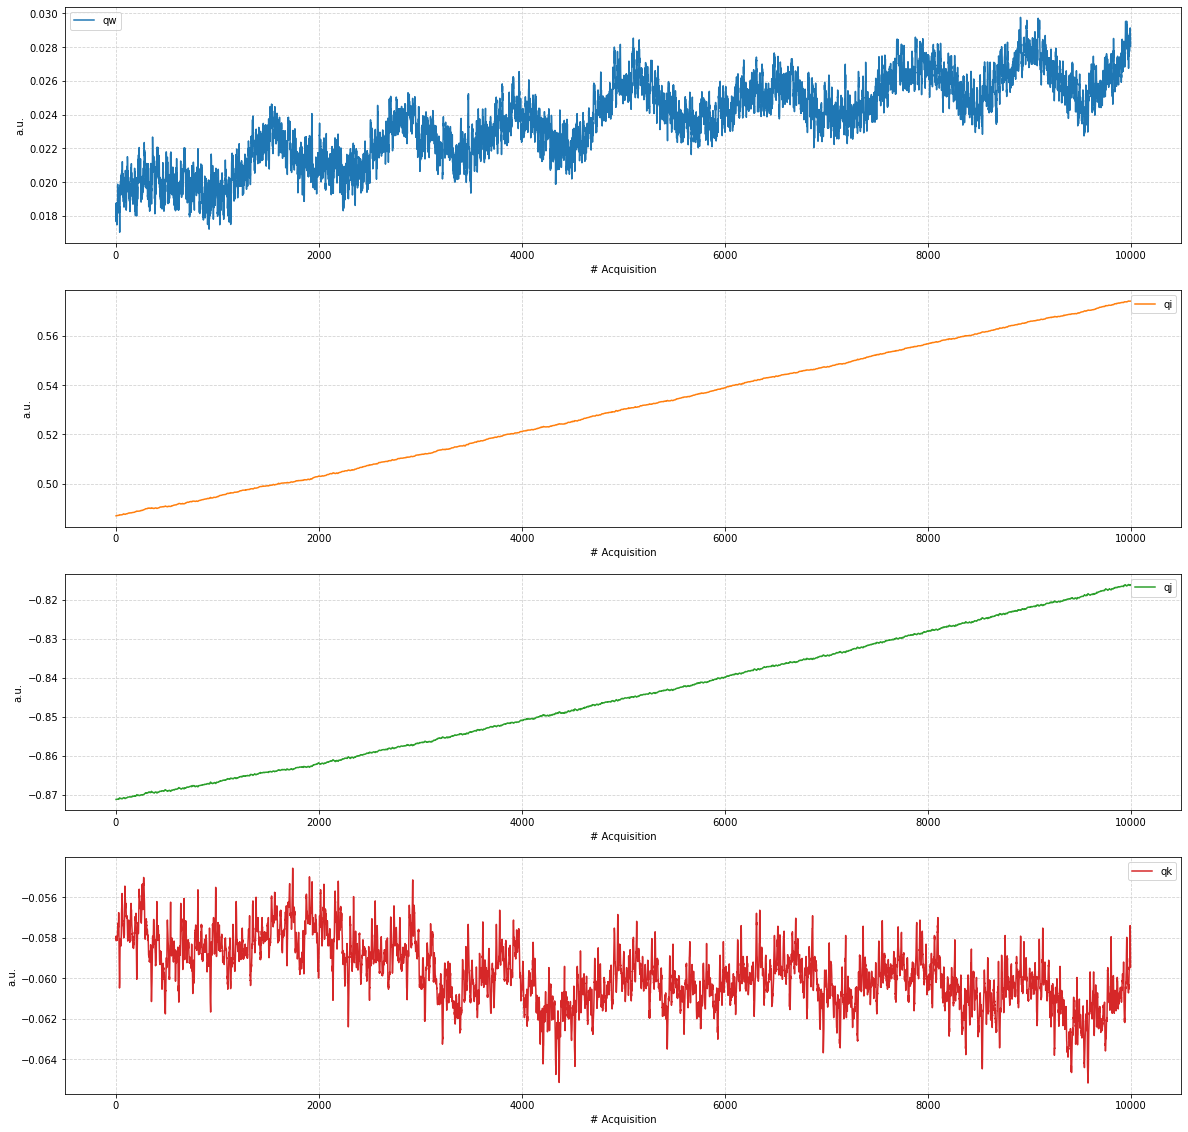

In [16]:
fig, ax = plt.subplots(nrows=4,figsize=(20, 20))
xyz = ["w","i","j","k"]
colors=plt.rcParams['axes.prop_cycle'].by_key()['color']

for c in range(4):
    ax[c].plot(data.loc[:,"q"+xyz[c]], color=colors[c], label="q"+xyz[c])
    ax[c].set_xlabel("# Acquisition")
    ax[c].set_ylabel("a.u.")
    ax[c].set_axisbelow(True)
    ax[c].grid(color='lightgray', linestyle='dashed')
    ax[c].legend()
    

### Breath frequency (tipically 12-16 breaths per minute $_{Wikipedia}$ )

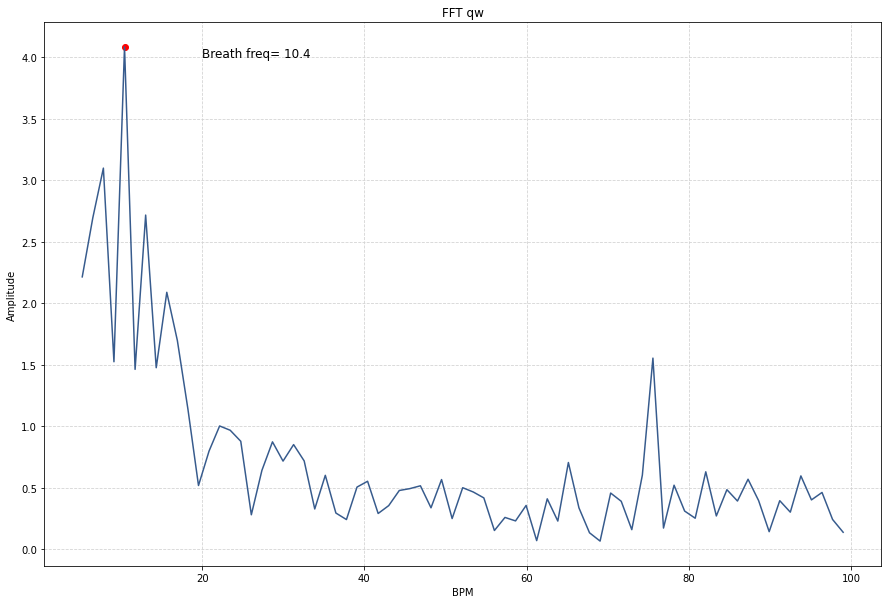

In [17]:
l=np.array(data["qw"])

f = pd.DataFrame({     #Dataframe with powers of fft as a function of the frequencies 
    "freq": 60*fftpack.fftfreq(l.size, d=1/mean_sampling), 
    "power":abs(fftpack.fft(l)),
    "fourier":fftpack.fft(l)
})

f=f[(f["freq"]>4)&(f["freq"]<100)] #FT restricted from 30 to 120 BPM
f = f.reset_index(drop=True)

max_freq= f.loc[np.argmax(f["power"]),"freq"]
max_amp = np.max(f["power"])
    
fig, ax = plt.subplots(figsize=(15, 10))    
ax.plot(f["freq"], f["power"], color=random_color())
ax.set_title("FFT qw")
ax.set_xlabel("BPM") 
ax.set_ylabel("Amplitude") 
ax.set_axisbelow(True)
ax.grid(color='lightgray', linestyle='dashed') 
ax.scatter(max_freq,max_amp, color="red")
plt.text(20, 4, 'Breath freq= %.1f'%max_freq, fontsize = 12)
plt.show()



### Rotation coordinates plots ($\sim$15 seconds)

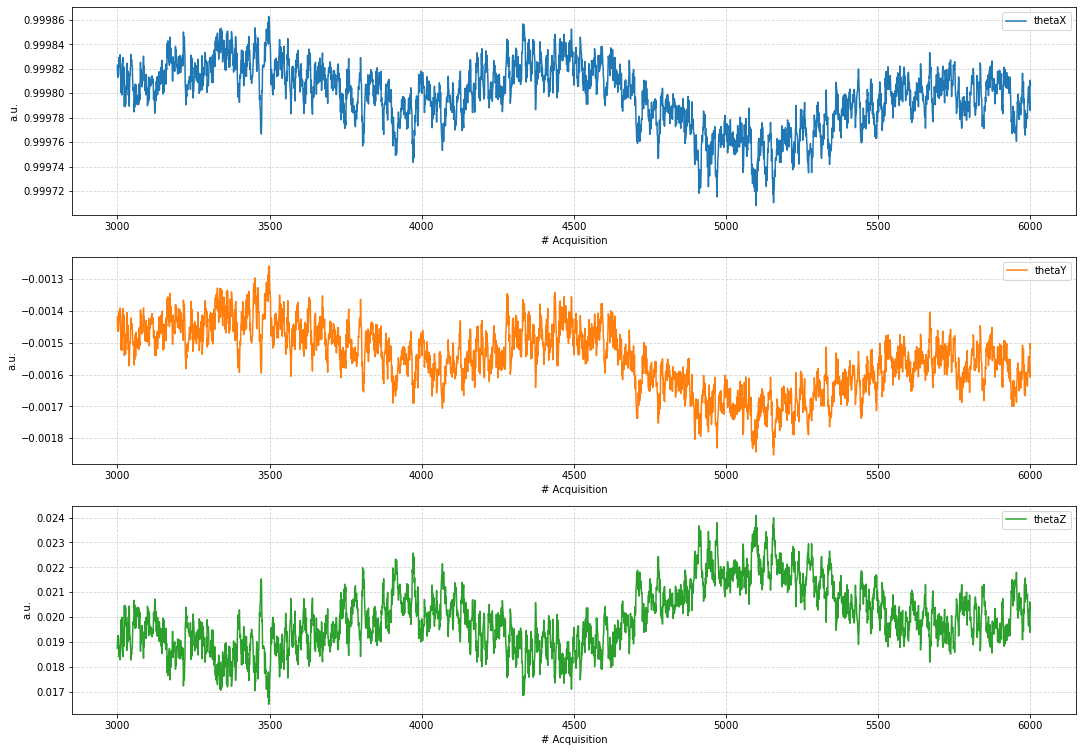

In [18]:
fig, ax = plt.subplots(nrows=3,figsize=(18, 13))

def plot_graph(title,a):
    colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
    ax[a].plot(data.loc[3000:6000,title], color=colors[a], label=title)
    ax[a].set_xlabel("# Acquisition")
    ax[a].set_ylabel("a.u.")
    ax[a].set_axisbelow(True)
    ax[a].grid(color='lightgray', linestyle='dashed')
    ax[a].legend()
    
plot_graph("thetaX",0)
plot_graph("thetaY",1)
plot_graph("thetaZ",2)

### 3D animation: quaternions

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
%matplotlib notebook

t = np.array([np.ones(1)*i for i in range(100)]).flatten()
steps=10000


def update_graph(num):
    #data=df[df['time']==num]
    f=1
    q = Quaternion(a=data.iloc[num]['qw']*f, n=np.array([data.iloc[num]['qi']*f,data.iloc[num]['qj']*f,data.iloc[num]['qk']*f]))
    q=q.normalized
    global vec_in
    vec=q.rotatePoint(vec_in)
    
    title.set_text('Rotation movement, time={}'.format(num))
    ax.lines[0].remove()
    line=ax.plot([-vec[0],vec[0]], [-vec[1],vec[1]],[-vec[2],vec[2]], color="red")

    

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
title =ax.set_title('Rotation movement')
ax.set_xlim((-1,1))
ax.set_ylim((-0.002,0.001))
ax.set_zlim((-0.01,0.025))
ax.quiver(-1, 0, 0, 2, 0, 0, arrow_length_ratio=0.003, color="black")
ax.quiver(0, -0.002, 0, 0, 0.0028, 0, arrow_length_ratio=0.003, color="black")
ax.quiver(0, 0, -0.01, 0, 0, 0.03, arrow_length_ratio=0.003, color="black")


ax.plot([0,1], [0,0], [0,0], color="red")
vec_in = np.array([1,0,0])

ani = matplotlib.animation.FuncAnimation(fig, update_graph, steps-1, interval=5, blit=False)
#ani.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.show()

![display image](quat_animation.gif)

## Variables selections

### Computing FT and SNR 
Let's define the "Signal to Noise Ratio" (SNR) as:

$$SNR = \frac{max_{30-120}(FT)}{ave^*(FT)}$$

where FT is the fft of the signal, $ave^*$ is its average in the interval f<60 BPM or f>100 BPM, supposed out of rage for the Heart Beat. 

We can use this indicator as criterium to proper select less noisy variables.

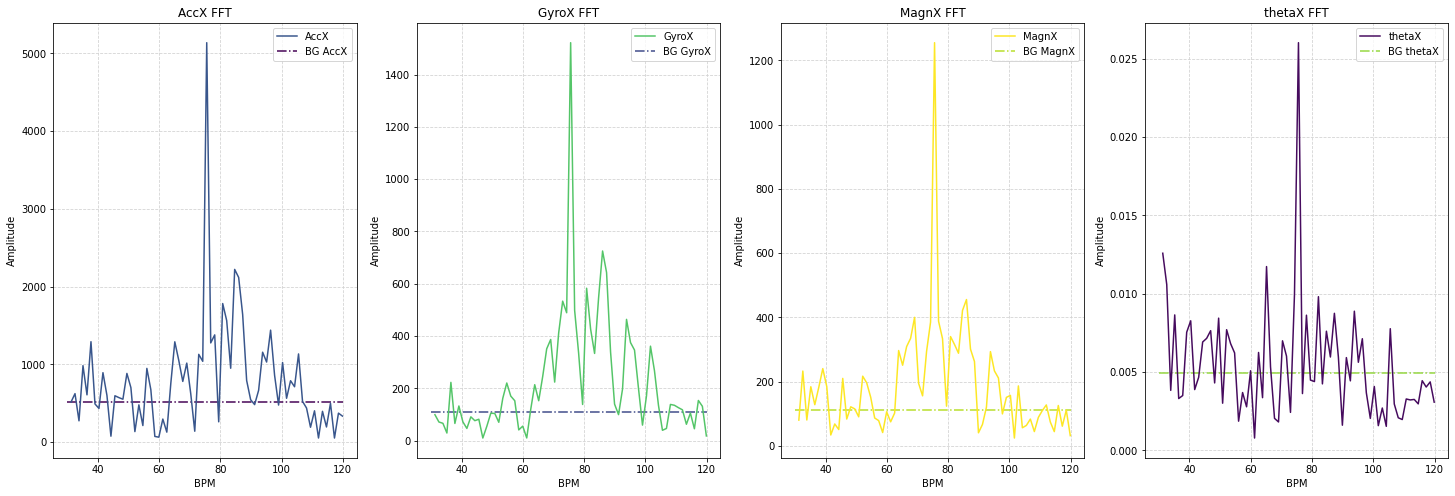

In [9]:
%matplotlib inline 

def FT(dat,restricted):   #Computes the fourier transform given a vector of data and returns a DF
    l=np.array(dat)

    f = pd.DataFrame({     #Dataframe with powers of fft as a function of the frequencies 
        "freq": 60*fftpack.fftfreq(l.size, d=1/mean_sampling), 
        "power":abs(fftpack.fft(l)),
        "fourier":fftpack.fft(l)
    })

    if restricted:
        return f[(f["freq"]>30)&(f["freq"]<120)] #FT restricted from 30 to 120 BPM
    else: 
        return f


def get_SNR(f_df):  #Computes and return the SNR of the FT in input
    positive=f_df[f_df["freq"]>40]  
    id_max= positive["power"].idxmax() #selects the frequency with maximum power
    
    freq_max= f_df["freq"][id_max] #freq and amplitude of the peak 
    ampl_max = f_df["power"][id_max]
    
    ave = np.mean(f_df["power"][np.logical_or(f_df["freq"]<60,f_df["freq"]>100)]) #average of signal below 60 and upper 100 bpm
    
    return (ampl_max/ave, freq_max, ave)

def plot_graph(f,ave,i, title): 
    ax[i].plot(f["freq"], f["power"], label=c, color=random_color())
    ax[i].hlines(ave,30,120,linestyles='dashdot', alpha=1, label="BG "+c, color=random_color())
    ax[i].set_title(title+" FFT")
    ax[i].legend(prop={'size': 10})
    ax[i].set_xlabel("BPM") 
    ax[i].set_ylabel("Amplitude") 
    ax[i].set_axisbelow(True)
    ax[i].grid(color='lightgray', linestyle='dashed')


#Consider only useful variables
data_reduced = data[data.columns[[*range(1,10),*range(14,20)]]]

snr_values, maxFT_values,ave,f = {},{},{},{} #Dictionary of useful datas

#Compute fft and snr of ALL variables
for c in data_reduced.columns:
    f[c] = FT(data[c], True)
    snr_values[c], maxFT_values[c], ave[c] = get_SNR(f[c])
        

#Plot some of these variable's fft        
fig, ax = plt.subplots(ncols=4,figsize=(25,8))
       
for c,i in zip(["AccX","GyroX","MagnX","thetaX"],range(4)): 
    plot_graph(f[c],ave[c],i,c)
    

### Signal to Noise Ratio of the FT 

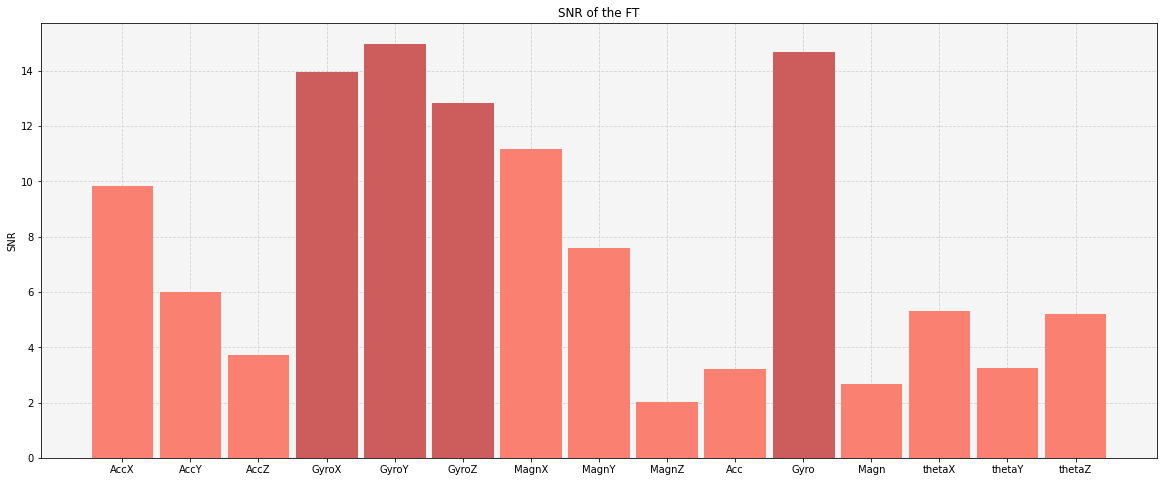

In [10]:
fig,ax = plt.subplots(figsize=(20, 8))
bar_snr= ax.bar(snr_values.keys(), snr_values.values(), color ='salmon', width = 0.9)
max_snr= np.argsort(list(snr_values.values())) #finds the indexes of the higher SNR
for i in max_snr[-4:]: bar_snr[i].set_color('indianred')
ax.set_title('SNR of the FT')
ax.set_ylabel('SNR')  
ax.set_facecolor('whitesmoke')
ax.set_axisbelow(True)
ax.grid(color='lightgray', linestyle='dashed')
plt.show()

From SNR's values we can make a ranking of most significative variables to probe the heart beat:
* Gyros are the best variables
* Accs (and at the same position) Magn in the second position
* rotations (theta X, Y, Z) are the most noisy ones

## Statistical analysis

In [12]:
#Select best 4 features
best_features = np.array([i for i in snr_values.keys()])[max_snr[-4:]]
data_best = data[best_features]
print("Best 4 feature to describe the heartbeat, from SNR analysis: ")

stat = data_best.describe().transpose()
stat['median']=data_best.median()
stat['variance']=stat['std']**2

stat.drop(['count'],axis=1)


Best 4 feature to describe the heartbeat, from SNR analysis: 


mean       std        min       25%       50%       75%        max  \
GyroZ -1.586797  0.363792  -3.222214 -1.832901 -1.573359 -1.344351  -0.199313   
GyroX -4.332174  1.426187 -12.242224 -4.929247 -4.394896 -3.723140   2.231058   
Gyro   8.218217  0.823934   4.573729  7.795755  8.106124  8.437225  14.678534   
GyroY  6.651985  0.719195   3.467280  6.245906  6.612318  6.978730   9.650486   

         median  variance  
GyroZ -1.573359  0.132345  
GyroX -4.394896  2.034011  
Gyro   8.106124  0.678866  
GyroY  6.612318  0.517242

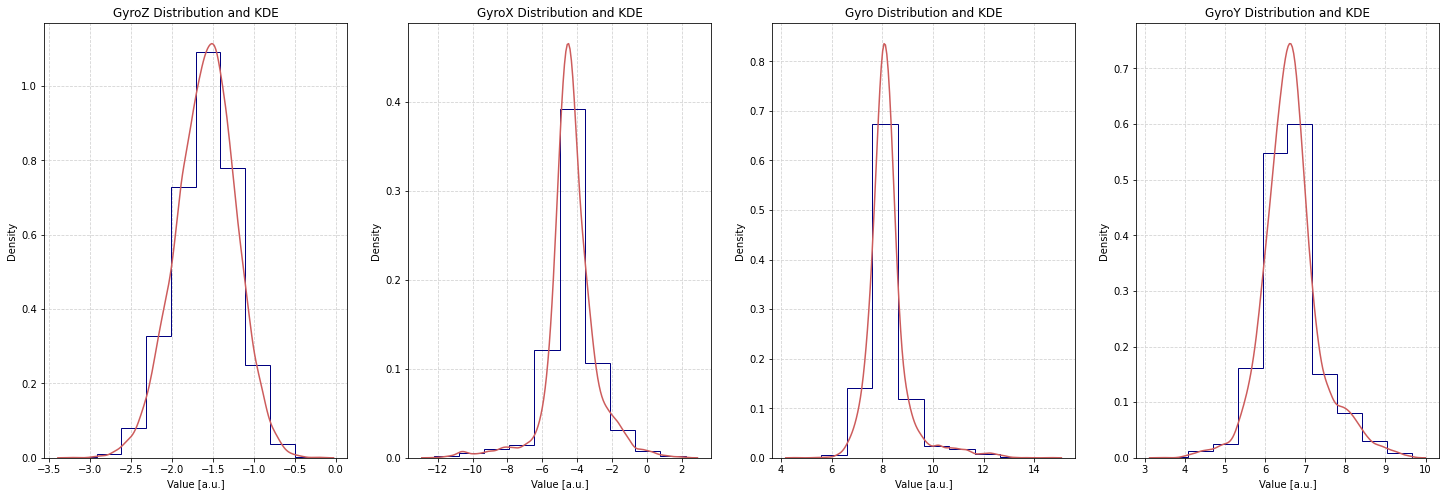

In [14]:
def hist_plot(x,title,i):
    h, bins, _ = ax[i].hist(x, color='navy',histtype="step", density=True)
    ax[i].set_title(title+" Distribution and KDE")
    ax[i].set_xlabel("Value [a.u.]")
    ax[i].set_ylabel("Density")
    ax[i].grid(color='lightgray', linestyle='dashed')
    
fig, ax = plt.subplots(ncols=4,figsize=(25, 8))
for c,j in zip(data_best,range(4)):
    hist_plot(data_best[c],c,j)
    sns.kdeplot(data_best[c], ax=ax[j], color='indianred')

### PCA Analysis

Covariance matrix:
           GyroZ     GyroX      Gyro     GyroY
GyroZ  0.132345  0.199839 -0.041315  0.115499
GyroX  0.199839  2.034011 -0.769132  0.405243
Gyro  -0.041315 -0.769132  0.678866  0.217250
GyroY  0.115499  0.405243  0.217250  0.517242


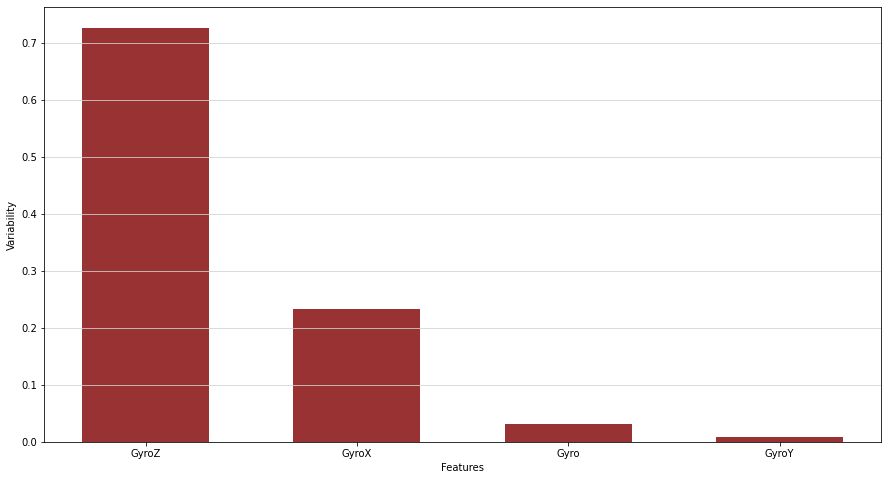

In [15]:
print('Covariance matrix:\n',data_best.cov())

#PCA
data_best_centered= np.array((data_best-data_best.mean()))

U, D, Vt = la.svd(data_best_centered)
eig= D**2/(len(data_best_centered)-1)

#Equivalent to PCA with 
#l, V = la.eig(data_best.cov())
#eig = np.real_if_close(l)

def plot_variability(data, var):
    ax.bar([i for i in data], var, color ='maroon', width = 0.6, alpha=0.8)
    ax.set_xlabel("Features")
    ax.grid(color='lightgray', linestyle='solid', axis='y')
    ax.set_ylabel("Variability")


fig, ax = plt.subplots(figsize=(15,8))

variability = eig/np.sum(eig)
plot_variability(data_best, variability)


The 4 features are quite well correlated as expected. The variability reach 70% of the full set if we consider just 1 variables and it quickly goes over 90% with two of them. With 3 variables it hits approximately the unity. 

This is expected since "Gyro" is directly derived from the combination of the other 3.

## Fourier Analysis

With a mean sampling frequency of 217.18 Hz, the maximum frequency of the signal is 108.59 Hz, which correspond to 6515 BPM


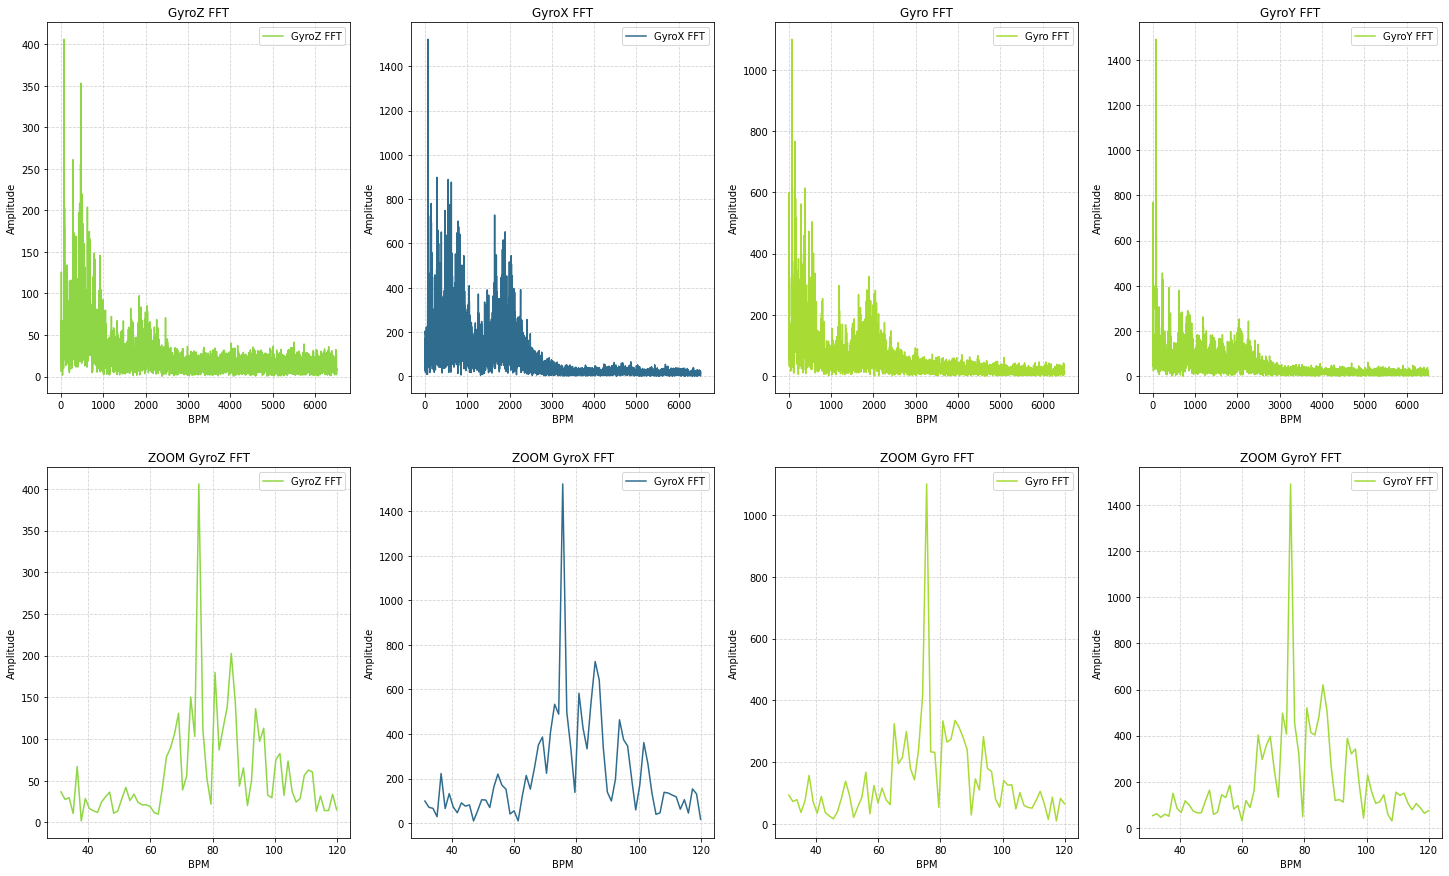

In [16]:
# See FT function defined above at SNR section!
colors = [random_color() for i in range(4)]

def plot_fft(f,j,i, title, col,l): 
    ax[i,j].plot(f["freq"], f["power"], label=l, color=col)
    ax[i,j].set_title(title+" FFT")
    ax[i,j].legend(prop={'size': 10})
    ax[i,j].set_xlabel("BPM") 
    ax[i,j].set_ylabel("Amplitude") 
    ax[i,j].set_axisbelow(True)
    ax[i,j].grid(color='lightgray', linestyle='dashed')
    
def plot_fft_single(f,i, title, col,l): 
    ax[i].plot(f["freq"], f["power"], label=l, color=col)
    ax[i].set_title(title+" FFT")
    ax[i].legend(prop={'size': 10})
    ax[i].set_xlabel("BPM") 
    ax[i].set_ylabel("Amplitude") 
    ax[i].set_axisbelow(True)
    ax[i].grid(color='lightgray', linestyle='dashed')

    
full_fft = {} #Saving the FT for further purpose

fig, ax = plt.subplots(ncols=4, nrows=2,figsize=(25, 15))
for c,i in zip(data_best,range(4)): 
    full_fft[c] = FT(data_best[c], False)
    plot_fft(full_fft[c][(full_fft[c]["freq"]>0)],i,0,c,colors[i],c+' FFT') #Plot just positive frequencies
    plot_fft(FT(data_best[c], True),i,1,"ZOOM "+c, colors[i],c+' FFT')
                     
print("With a mean sampling frequency of %.2f Hz, the maximum frequency of the signal is %.2f Hz, which correspond to %i BPM" %(mean_sampling,mean_sampling/2,60*mean_sampling/2))
 

                     

The highest peak is always around 80 BPM, even if we consider the full fourier transform

### Fitting of FFT: BPM and HRV estimation

Fitting prameters: [mean, sigma, amplitude]
GyroZ 	 [ 81.45746967  16.29766944 122.88807203] Chi-sq: 2593.75	
GyroX 	 [ 80.44625129  14.20779331 511.67331921] Chi-sq: 10653.19	
Gyro 	 [ 78.32260446  14.99199875 311.47615764] Chi-sq: 5736.72	
GyroY 	 [ 79.25475746  14.67429092 458.31279218] Chi-sq: 9535.81	


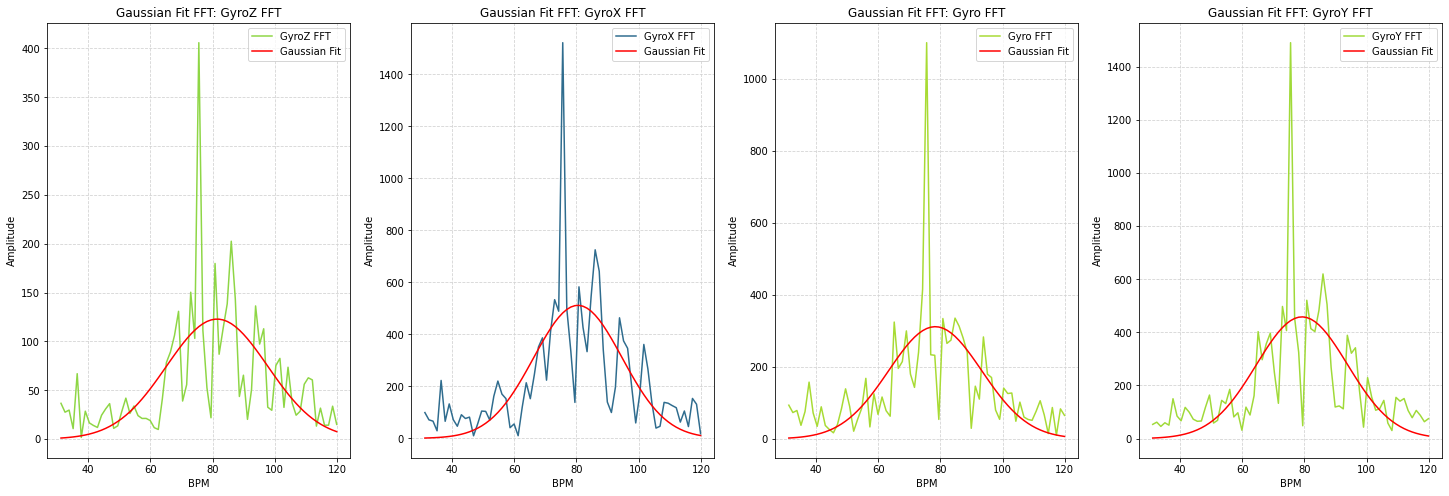

In [17]:
#Model function: c*N(mu, sigma)
def normal(x, mu, sigma, c): return c*stats.norm.pdf(x,mu,sigma)*m.sqrt(2*m.pi)*sigma

def pvalue(obs,exp,ddof):
    chi2 = np.sum(((obs - exp)**2) / np.abs(obs) )
    pvalue = 1. - stats.chi2.cdf(chi2, ddof)
    return [chi2,pvalue]

def fit_fft(fft,i,l,col):
    x = fft[(fft['freq']>30)&(fft['freq']<120)]['freq'] 
    y = fft[(fft['freq']>30)&(fft['freq']<120)]['power']
    A=y.max()   
    params, _ = optimize.curve_fit(normal, x, y, p0=[75,20,A], full_output=False)
    chi2,p = pvalue(y,normal(x,params[0],params[1],params[2]),len(x)-3)
    
    #Plotting
    ax[i].plot(x,normal(x,params[0],params[1],params[2]), label=l, color=col)
    ax[i].legend(prop={'size': 10})
    
    return params,chi2,p

pars = {} #Saving fitting parameters

print("Fitting prameters: [mean, sigma, amplitude]")
fig, ax = plt.subplots(ncols=4, nrows=1,figsize=(25, 8))
for c,i in zip(full_fft,range(4)): 
    plot_fft_single(full_fft[c][(full_fft[c]['freq']>30)&(full_fft[c]['freq']<120)],i,"Gaussian Fit FFT: "+c, colors[i],c+" FFT") 
    
    pars[c],chi2,p = fit_fft(full_fft[c],i,"Gaussian Fit",'red')
    print(c,"\t",pars[c],"Chi-sq: %.2f\t" 
          %(chi2)) #FWHM = 2.355 sigma for normal    
    

Since chi2 value is very larger than the expected and p-value is very close to 0, the fit is very unprecise.

However we show the following results

In [27]:
results_fit = pd.DataFrame(pars).T
results_fit.columns = ['Mean','Std','Constant']
results_fit.loc['Average'] = results_fit.mean()
results_fit['Upper HR'] = results_fit['Mean']+results_fit['Std']
results_fit['Lower HR'] = results_fit['Mean']-results_fit['Std']
results_fit.loc['Average','Constant'] = '//'
results_fit

Mean        Std    Constant   Upper HR   Lower HR
GyroZ    81.457470  16.297669  122.888072  97.755139  65.159800
GyroX    80.446251  14.207793  511.673316  94.654045  66.238458
Gyro     78.322604  14.991999  311.476159  93.314603  63.330606
GyroY    79.254757  14.674291  458.312791  93.929048  64.580467
Average  79.870271  15.042938          //  94.913209  64.827333

## Filters

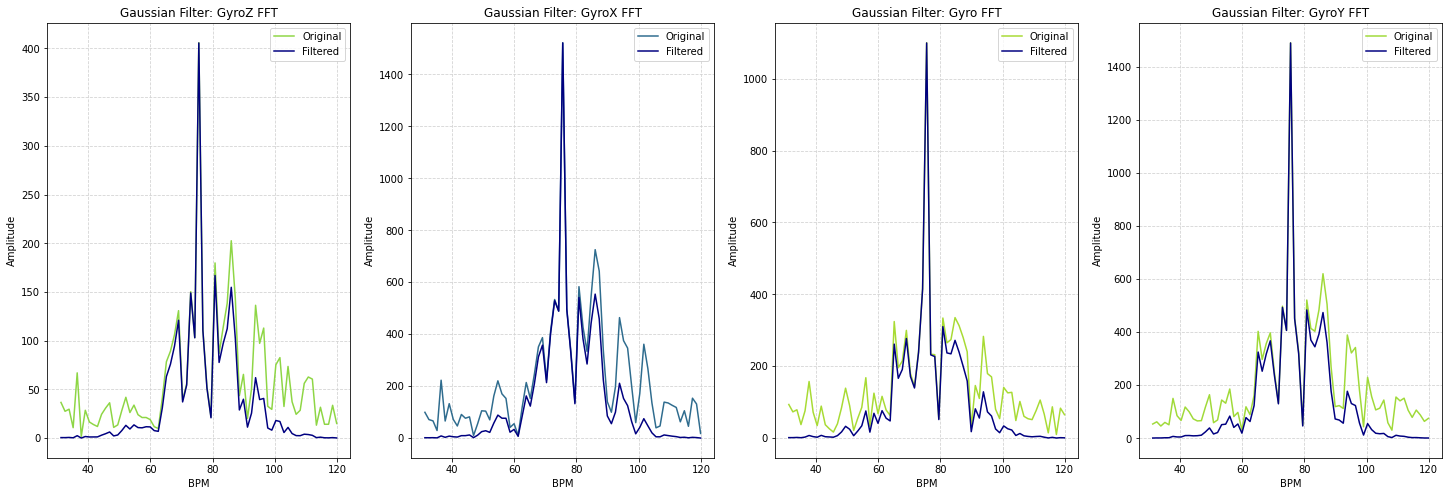

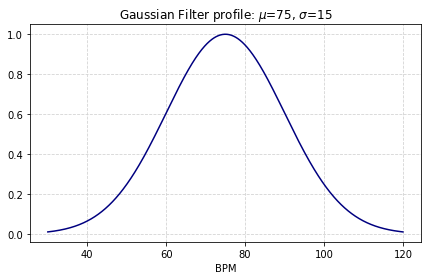

In [18]:
#Gaussian Filter definition
def filter_FT(original_FT, mu,sigma):
    FT = original_FT.copy()
    FT.loc[(FT["freq"]<30)|(FT["freq"]>120),"power"]=0 #Band-pass filter between 30 and 120 bpm

    FT["power"]=FT["power"]*stats.norm.pdf(FT["freq"], mu, sigma)*m.sqrt(2*m.pi)*sigma #Gaussian filter
    FT["fourier"]=FT["fourier"]*stats.norm.pdf(FT["freq"], mu, sigma)*m.sqrt(2*m.pi)*sigma
    
    return FT

def filter_plot(mu,sigma):
    x = np.linspace(30,120, 1000)
    ax.plot(x, stats.norm.pdf(x, mu, sigma)*m.sqrt(2*m.pi)*sigma, label="filter profile", color='navy')
    ax.set_title("Gaussian Filter profile: $\mu$=%i, $\sigma$=%i"%(cutoff,Q))
    ax.set_xlabel("BPM") 
    ax.set_axisbelow(True)
    ax.grid(color='lightgray', linestyle='dashed')
    

def plot_fft_single(f,i,title, col,l): 
    ax[i].plot(f["freq"], f["power"], label=l, color=col)
    ax[i].set_title(title+" FFT")
    ax[i].legend(prop={'size': 10})
    ax[i].set_xlabel("BPM") 
    ax[i].set_ylabel("Amplitude") 
    ax[i].set_axisbelow(True)
    ax[i].grid(color='lightgray', linestyle='dashed')
    

cutoff,Q =75,15 #Since from the fit, sigma ~ 15
fft_f = {} #Just saving the filtered FFT full

fig, ax = plt.subplots(ncols=4, nrows=1,figsize=(25, 8))
for c,i in zip(full_fft,range(4)): 
    fft_u = full_fft[c]
    fft_f[c] = filter_FT(full_fft[c],cutoff,Q)
    plot_fft_single(fft_u[(fft_u['freq']>30)&(fft_u['freq']<120)],i,"", colors[i],"Original")
    plot_fft_single(fft_f[c][(fft_f[c]['freq']>30)&(fft_f[c]['freq']<120)],i,"Gaussian Filter: "+c, 'navy',"Filtered")   
    
fig, ax = plt.subplots(figsize=(7, 4))
filter_plot(cutoff,Q) 


### Antitrasforming: Heart Beat signal

#### Antitransform FT with band-pass filter

In [19]:
#Using FT with band-pass filter
def FT(data):
    l=np.array(data)
    f = pd.DataFrame({     #Dataframe with powers of fft as a function of the frequencies 
            "freq": 60*fftpack.fftfreq(l.size, d=1/mean_sampling), 
            "power":abs(fftpack.fft(l)),
            "fourier":fftpack.fft(l)
        })
    f.loc[(f["freq"]<30)|(f["freq"]>120),"fourier"]=0 
    filtered_sig = fftpack.ifft(np.array(f["fourier"]))
    real_filtered_signal = np.real(filtered_sig)
    return real_filtered_signal

def filtered_signals(fft_f):
    res = {}
    for k in fft_f.keys():
        filtered_sig = FT(data[k])
        res[k] = np.real(filtered_sig)
    return res
signals_fil=filtered_signals(fft_f)

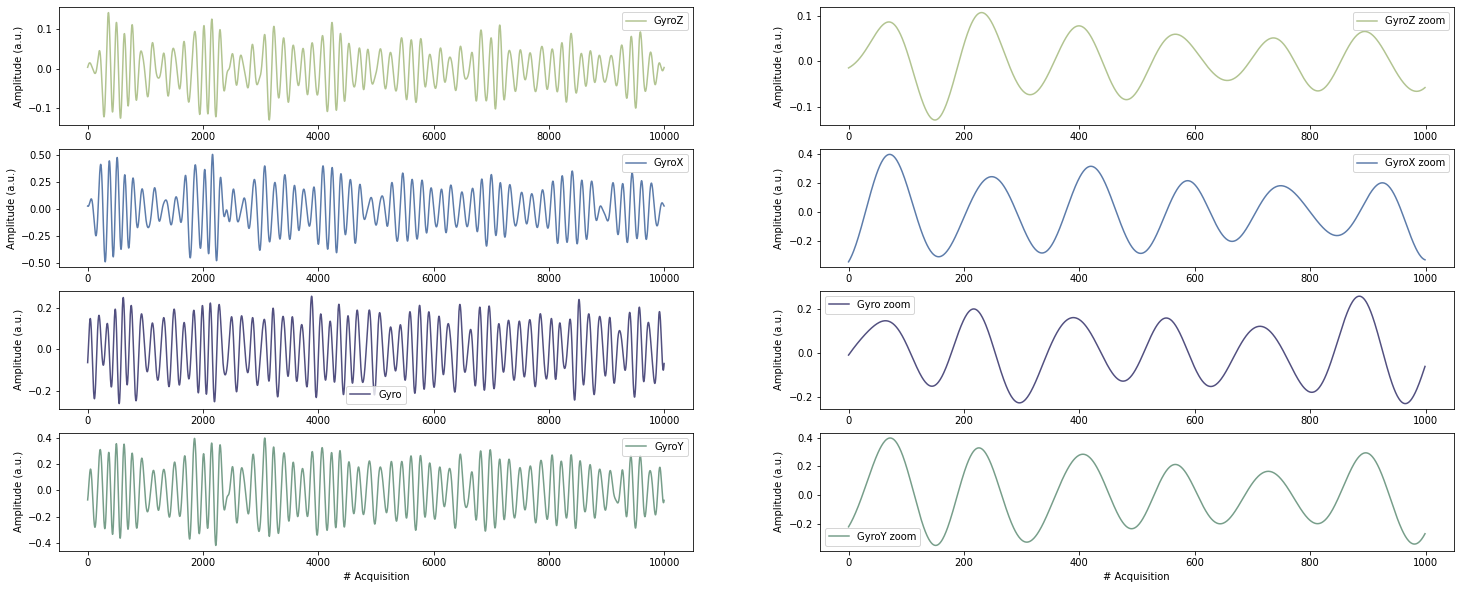

In [20]:
fig, ax = plt.subplots(ncols=2, nrows=4,figsize=(25, 10))
color={0:"#B2C491",1:"#5D7CAA",2:"#525080",3:"#779E8A"}
for k,i in zip(signals_fil.keys(),range(4)): 
    ax[i][0].plot(signals_fil[k],color[i] ,label=k)
    ax[i][1].plot(signals_fil[k][3000:4000],color[i],label=k+" zoom")
    ax[i][0].legend()
    ax[i][1].legend()
    ax[i][0].set_ylabel("Amplitude (a.u.)")
    ax[i][1].set_ylabel("Amplitude (a.u.)")
ax[3][0].set_xlabel("# Acquisition")
ax[3][1].set_xlabel("# Acquisition")
plt.show()

In [21]:
def find_spikes(ranges):
    loc_max=argrelextrema(np.array(ranges), np.greater)[0]
    return loc_max

In [22]:
def print_bpm_hist(name,signal,i,ax):
    peaks = find_spikes(signal)
    """ax[0].plot(np.arange(0,len(signal)),signal,'-b',label=name)
    for p in peaks:
        ax[0].axvline(x = p, color = 'green', label = 'axvline - full height')"""
    beats=1/(np.diff(peaks)/220)*60
    beats = beats[(beats>30)&(beats<100)]
    n, bins, patches = ax[i][0].hist(x=beats, bins=15, color=color[i], alpha=0.7, rwidth=0.85, label=name)
    ax[i][0].legend()
    ax[i][0].set_axisbelow(True)
    ax[i][0].grid(color='lightgray', linestyle='dashed')
    mu, sigma = stats.norm.fit(beats)
    best_fit_line = stats.norm.pdf(bins, mu, sigma)
    ax[i][1].plot(bins, best_fit_line, label=name, color=color[i])
    ax[i][1].legend()
    if i < 3:
        #ax[i][1].set_xticks([])
        #ax[i][0].set_xticks([])
        ax[i][0].set_ylabel("Count")
        ax[i][1].set_ylabel("Distribution")
    print(f"{name} mean BPM :{mu}, HRV : {mu - sigma} - {mu + sigma}")
    if i == 3:
        ax[3][0].set_xlabel("BPM")
        ax[3][0].set_ylabel("Count")
        ax[3][1].set_xlabel("BPM")
        ax[3][1].set_ylabel("Distribution")

GyroZ mean BPM :78.58999419732153, HRV : 69.32228606594948 - 87.85770232869358
GyroX mean BPM :78.17030729962246, HRV : 70.56409120212544 - 85.77652339711949
Gyro mean BPM :78.40359906744494, HRV : 70.13357726282351 - 86.67362087206638
GyroY mean BPM :78.04447920606188, HRV : 69.99870142229418 - 86.09025698982958


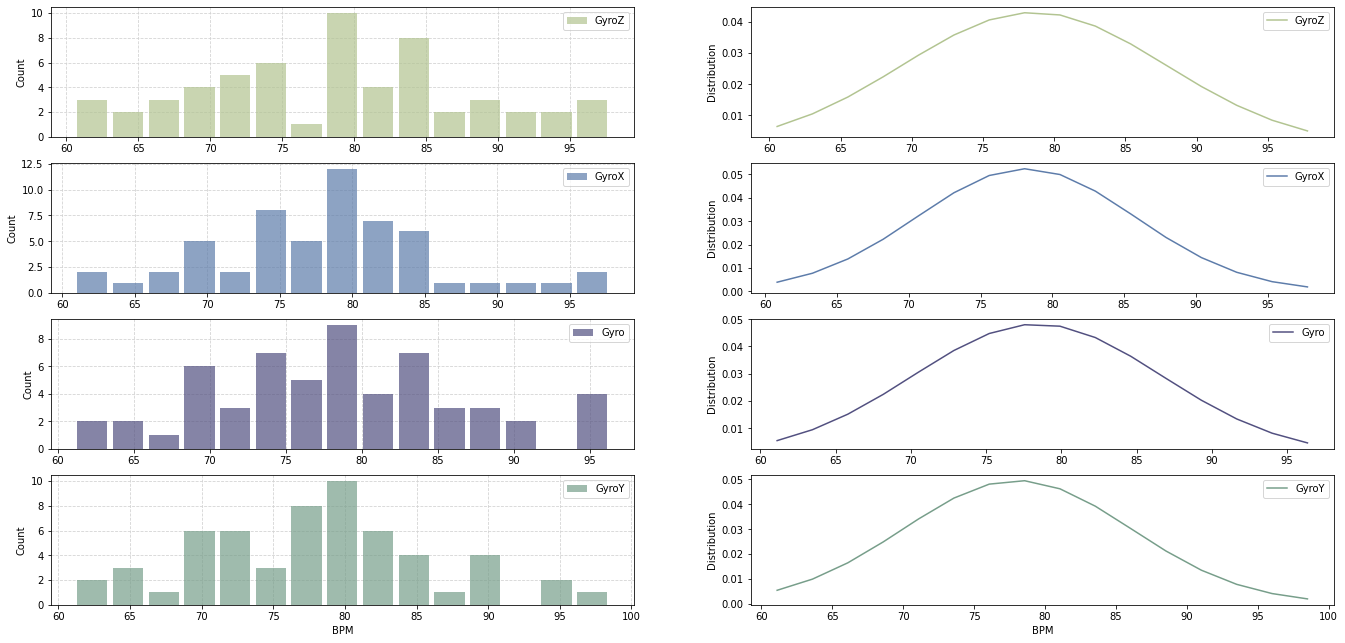

In [25]:
fig, ax = plt.subplots(ncols=2, nrows=4,figsize=(23, 11))
for k,i in zip(signals_fil.keys(),range(4)):
    print_bpm_hist(k, signals_fil[k], i,ax )

#### Antitransform FT with band-pass + gaussian filters

In [26]:
def filtered_signals(fft_f):  #Makes a dictioary of filtered (band-pass + gaussian) Anti-Transforms signals
    res = {}
    for k in fft_f.keys():
        filtered_sig = fftpack.ifft(np.array(fft_f[k]["fourier"]))
        res[k] = np.real(filtered_sig)
    return res

signals_fil=filtered_signals(fft_f)


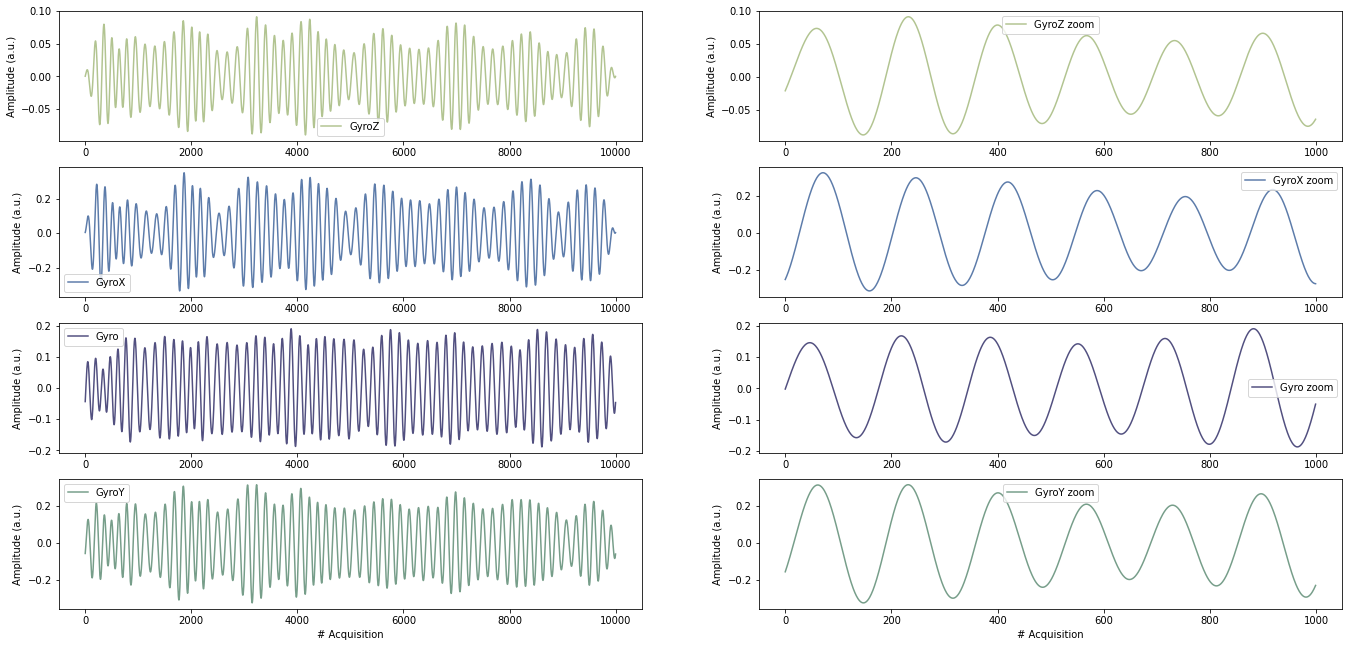

In [27]:
fig, ax = plt.subplots(ncols=2, nrows=4,figsize=(23, 11))
color={0:"#B2C491",1:"#5D7CAA",2:"#525080",3:"#779E8A"}
for k,i in zip(signals_fil.keys(),range(4)): 
    ax[i][0].plot(signals_fil[k],color[i] ,label=k)
    ax[i][1].plot(signals_fil[k][3000:4000],color[i],label=k+" zoom")
    ax[i][0].legend()
    ax[i][1].legend()
    ax[i][0].set_ylabel("Amplitude (a.u.)")
    ax[i][1].set_ylabel("Amplitude (a.u.)")
ax[3][0].set_xlabel("# Acquisition")
ax[3][1].set_xlabel("# Acquisition")

plt.show()

GyroZ mean BPM :77.87154737418939, HRV : 72.0453512719109 - 83.69774347646788
GyroX mean BPM :77.83627637837249, HRV : 72.0202892530775 - 83.65226350366748
Gyro mean BPM :78.14389151812016, HRV : 71.94984460344568 - 84.33793843279463
GyroY mean BPM :78.12543464421488, HRV : 71.86265276917607 - 84.38821651925369


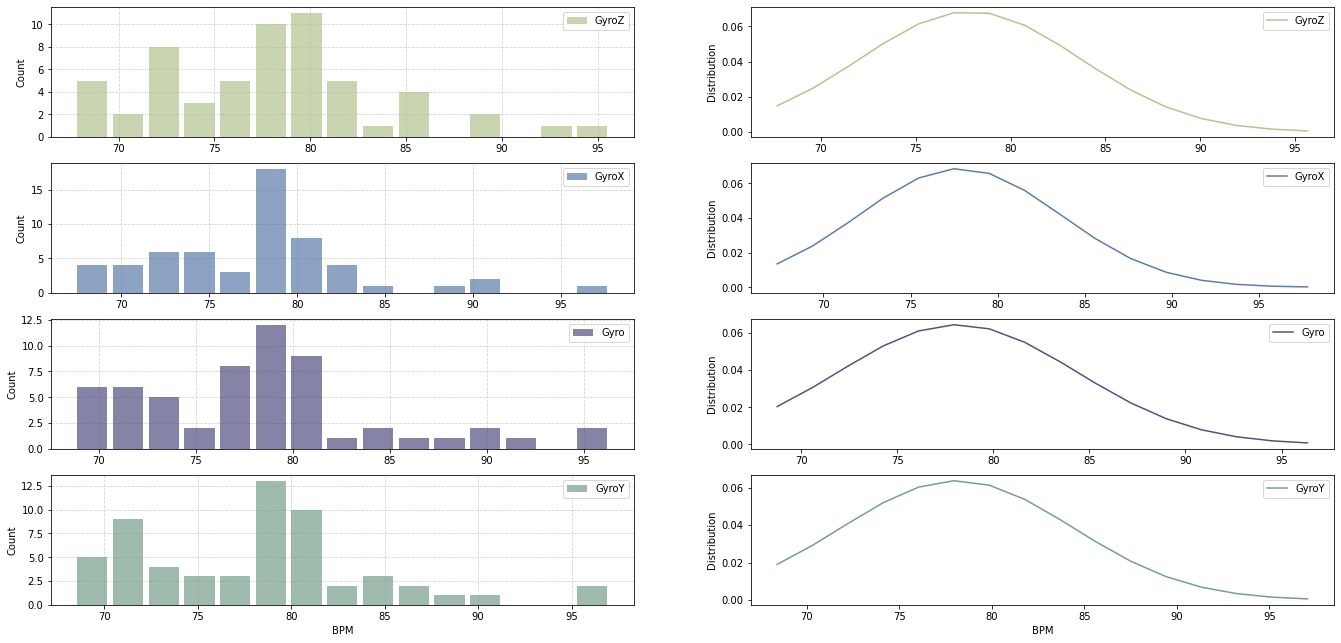

In [28]:
fig, ax = plt.subplots(ncols=2, nrows=4,figsize=(23, 11))
for k,i in zip(signals_fil.keys(),range(4)):
    print_bpm_hist(k, signals_fil[k], i,ax )

### Optional: extrapolating the Heart rate with a threshold

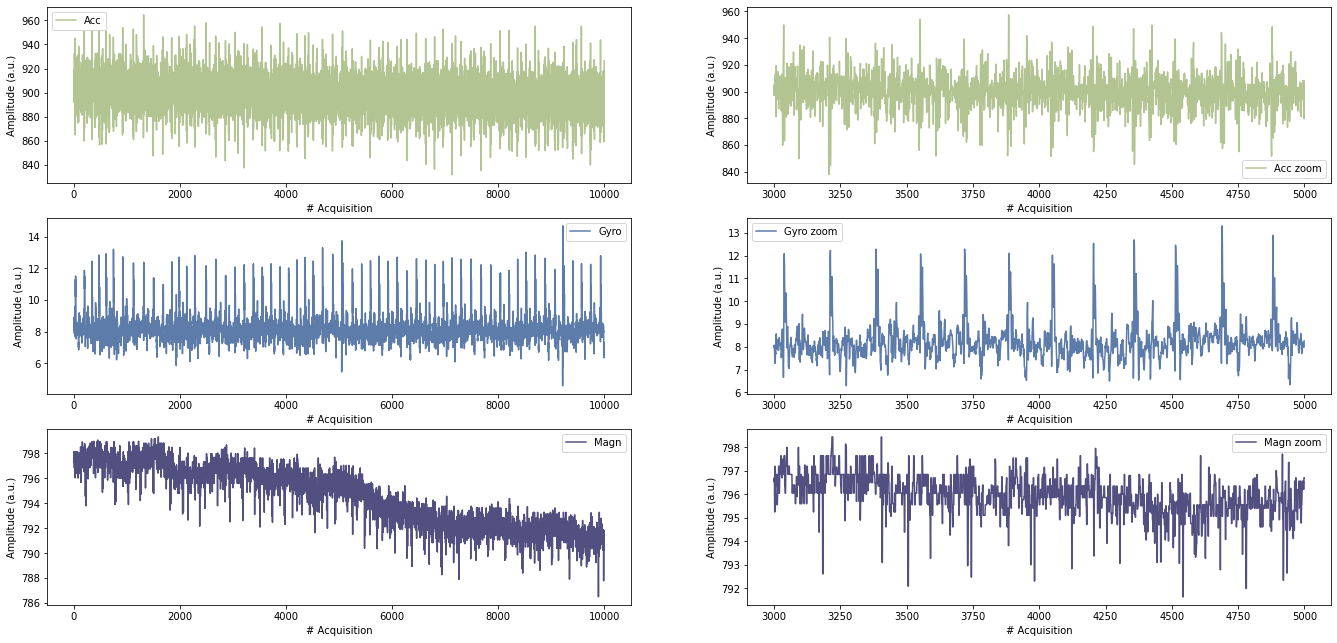

In [29]:
fig, ax = plt.subplots(ncols=2, nrows=3,figsize=(23, 11))
for k,i in zip(modules.keys(),range(3)):
    ax[i][0].plot(modules[k],color=color[i],label=k)
    ax[i][1].plot(modules[k][3000:5000],color=color[i],label=k+" zoom")
    ax[i][0].legend()
    ax[i][1].legend()
    ax[i][0].set_xlabel("# Acquisition")
    ax[i][0].set_ylabel("Amplitude (a.u.)")
    ax[i][1].set_xlabel("# Acquisition")
    ax[i][1].set_ylabel("Amplitude (a.u.)")

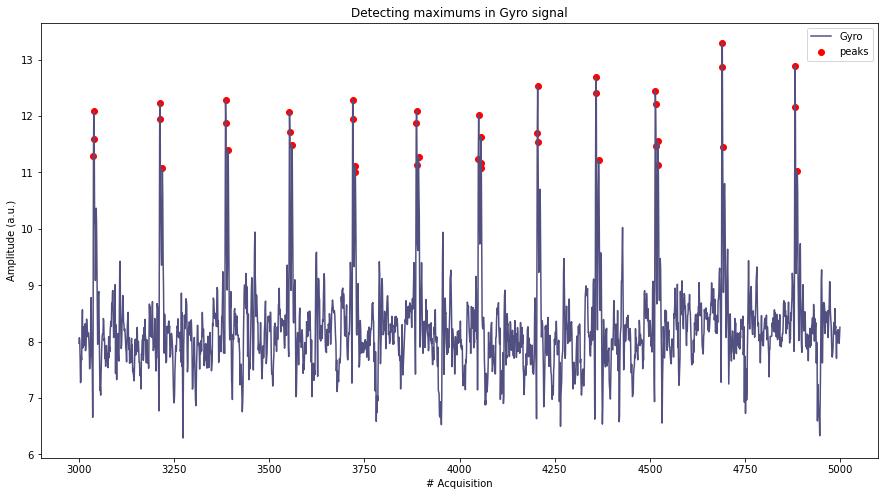

In [38]:
gyro = modules["Gyro"]
threshold = 11
peaks = np.where(gyro >= threshold)[0]
peaks_limited= peaks[np.where((peaks>3000)&(peaks<5000))[0]]
plt.figure(figsize=(15,8))
plt.plot(gyro[3000:5000] ,label="Gyro", color="#525080")
plt.scatter(peaks_limited,gyro[peaks_limited],color="red",label="peaks")
plt.title("Detecting maximums in Gyro signal")
plt.xlabel("# Acquisition")
plt.ylabel("Amplitude (a.u.)")
plt.legend()
plt.show()

As we can see, we are detecting multiple peaks for the same beat $\rightarrow$ we need to group them and select one


In [39]:
peaks_f=[]
bins=[peaks[0]]
for i in range(1,len(peaks)):
    if peaks[i]-peaks[i-1]<20:
        bins.append(peaks[i])
    else :
        peaks_f.append(bins[np.argmax(data.loc[bins, "Gyro"])]) #selects the maximum peak between the multiple ones
        bins=[peaks[i]]
peaks_f = np.array(peaks_f)  #Array of the local maximum corresponding to the hart beats

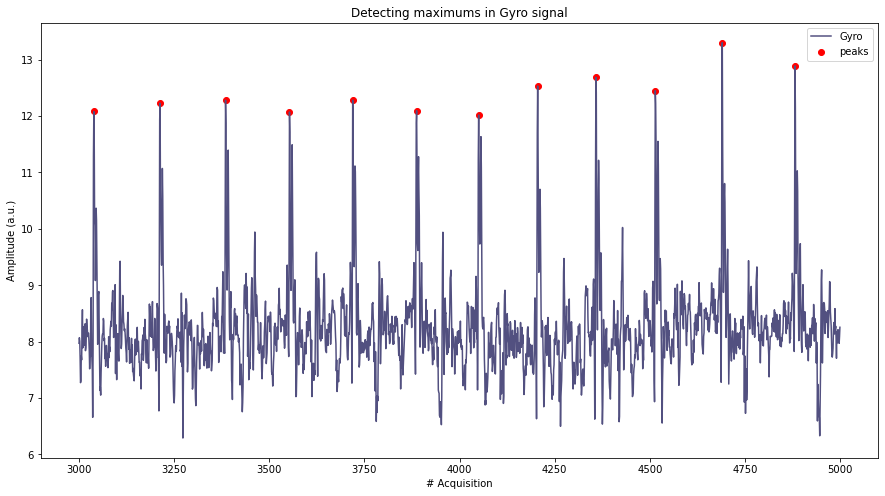

In [40]:
plt.figure(figsize=(15,8))
plt.plot(gyro[3000:5000] ,label="Gyro", color="#525080")
plt.scatter(peaks_f[np.where((peaks_f>3000)&(peaks_f<5000))[0]],gyro[peaks_f[np.where((peaks_f>3000)&(peaks_f<5000))[0]]],color="red",label="peaks")
plt.title("Detecting maximums in Gyro signal")
plt.xlabel("# Acquisition")
plt.ylabel("Amplitude (a.u.)")
plt.legend()
plt.show()

Estimated mean BPM : 84.60488703108179, HRV : 59.10987328879081


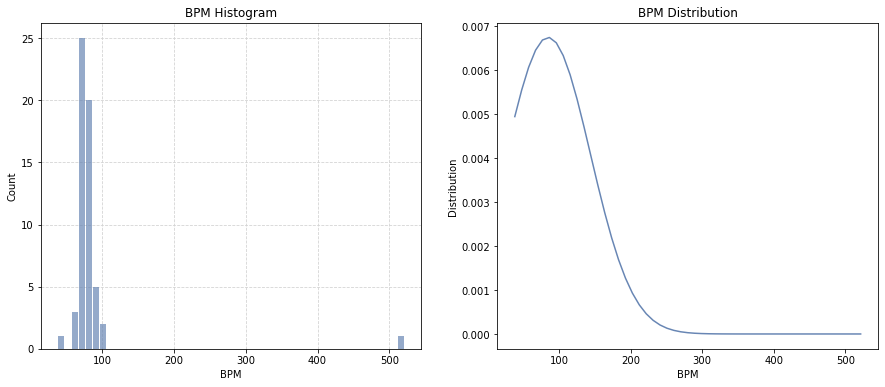

In [41]:
beats=1/(np.diff(peaks_f)/mean_sampling)*60
fig, ax = plt.subplots(ncols=2, nrows=1,figsize=(15, 6))
n, bins, patches = ax[0].hist(x=beats, bins=50, alpha=0.7, rwidth=0.85, color="#6886b4")
ax[0].set_xlabel("BPM")
ax[0].set_ylabel("Count")
ax[0].set_title("BPM Histogram")
ax[0].set_axisbelow(True)
ax[0].grid(color='lightgray', linestyle='dashed')
mu, sigma = scipy.stats.norm.fit(beats)
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
ax[1].plot(bins, best_fit_line, label="Distribution", color="#6886b4")
print(f"Estimated mean BPM : {mu}, HRV : {sigma}")
ax[1].set_xlabel("BPM")
ax[1].set_ylabel("Distribution")
ax[1].set_title("BPM Distribution")
plt.show()

Estimated mean BPM : 77.51354633489733, HRV : 69.46141190662159 - 85.56568076317306


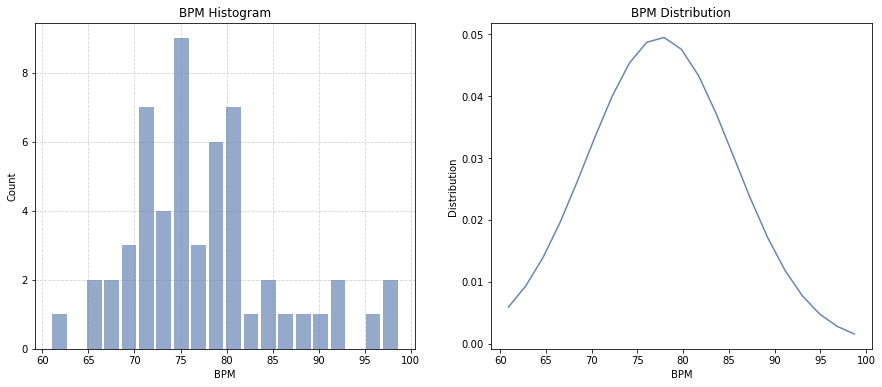

In [42]:
#removing the beats that are clearly a mistake "500"

beats=1/(np.diff(peaks_f)/mean_sampling)*60
beats = beats[(beats>40) & (beats<150)]
fig, ax = plt.subplots(ncols=2, nrows=1,figsize=(15, 6))
n, bins, patches = ax[0].hist(x=beats, bins=20, alpha=0.7, rwidth=0.85, color="#6886b4")
mu, sigma = scipy.stats.norm.fit(beats)
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
ax[1].plot(bins, best_fit_line, label="Distribution", color="#6886b4")
print(f"Estimated mean BPM : {mu}, HRV : {mu - sigma} - {mu + sigma}")
ax[0].set_xlabel("BPM")
ax[0].set_ylabel("Count")
ax[0].set_title("BPM Histogram")
ax[0].set_axisbelow(True)
ax[0].grid(color='lightgray', linestyle='dashed')
ax[1].set_xlabel("BPM")
ax[1].set_ylabel("Distribution")
ax[1].set_title("BPM Distribution")
plt.show()

## Trials with other files

In [43]:
def get_data(filename):  #Collects the data and returns a data frame
     return pd.read_csv(filename, sep="\t")

In [44]:
#Calibration of the data and modifies the dataframe with the data
R_gyro2 = np.identity(3)
off_gyro2 = np.array([-2.804399,1.793105,0.3411708])

R_acc2 = np.array([[1.002982, 9.415505E-05, 0.004346743], [9.04459E-05, 1.002731, -0.001444198], [0.004346536, -0.001444751, 1.030587]])
off_acc2 = np.array([3.602701,-20.96658, 54.97186])

R_mag2 = np.array([[1.013437,-0.04728858,-0.001861475],[-0.04728862,1.004832,0.008222118],[-0.001861605,0.008221965,0.9439077]])
off_mag2 = np.array([-150.4098, 74.62431, 630.9805])


def calibrate2(df, title, R, off):
    xyz = ["X","Y","Z"]
    col=np.array([title+ ax for ax in xyz])
    d = np.array(df.loc[:,col])
    
    for i in range(len(d)):
        d[i] = R.dot(d[i]) + off

    for i in range(3):
        df[col[i]]=d[:,i]
    
    
def call_calibrate(df):
    for n,r,o in zip(["Gyro","Acc","Magn"],[R_gyro2,R_acc2,R_mag2],[off_gyro2,off_acc2,off_mag2]):
    #for n,r,o in zip(["Gyro","Acc","Magn"],[R_gyro,R_acc,R_mag],[off_gyro,off_acc,off_mag]):
        calibrate2(df,n,r,o)
        

In [45]:
#Computes time informations of the data (start,end, mean sampling) and fills the time_info dataframe
def compute_time(df, filename):

    t_min = datetime.fromtimestamp(df["Timestamp"].min())  #acquisition starting time
    t_max = datetime.fromtimestamp(df["Timestamp"].max())  #acquisition ending time
    acquisition_seconds = (t_max-t_min).total_seconds()      #total acquisition time
    acq_per_sec = df.groupby("Timestamp").size()           #acquisitions per second
    mean_sampling = np.mean(acq_per_sec)         #mean sampling 

    time_info.loc[len(time_info)] = [filename, t_min,t_max, acquisition_seconds,df.shape[0],mean_sampling ]



In [46]:
#Computes the modules of Gyro, Acc and Magn adding the columns to the dataframe
def compute_module(df):
    xyz = ["X","Y","Z"]
    title = ["Acc","Gyro","Magn"]
    for t in title: 
        columns=np.array([t+ ax for ax in xyz])
        module = np.sqrt(np.square(df.loc[:,columns]).sum(axis=1))
        df[t]=module
        

In [47]:
def normal(x, mu, sigma, c): return c*stats.norm.pdf(x,mu,sigma)*m.sqrt(2*m.pi)*sigma

def fit_fft2(fft):
    x = fft[(fft['freq']>30)&(fft['freq']<120)]['freq'] 
    y = fft[(fft['freq']>30)&(fft['freq']<120)]['power']
    A=y.max()   
    try:
        params, _ = optimize.curve_fit(normal, x, y, p0=[75,15,A], full_output=False)
        return params[0], params[1], params[2]
    except: 
        return float("NaN"), float("NaN"), float("NaN")

In [48]:
#Computes fourier transforms of the data and fills the results into the fourier_info dataframe

def FT(dat,restricted, sampling_freq):   #Computes the fourier transform given a vector of data and returns a DF
    l=np.array(dat)

    f = pd.DataFrame({     #Dataframe with powers of fft as a function of the frequencies 
        "freq": 60*fftpack.fftfreq(l.size, d=1/sampling_freq), 
        "power":abs(fftpack.fft(l)),
        "fourier":fftpack.fft(l)
    })

    if restricted:
        return f[(f["freq"]>30)&(f["freq"]<120)] #FT restricted from 30 to 120 BPM
    else: 
        return f


def get_SNR(f_df):  #Computes and return the SNR of the FT in input
    positive=f_df[f_df["freq"]>40]  
    id_max= positive["power"].idxmax() #selects the frequency with maximum power
    
    freq_max= f_df["freq"][id_max] #freq and amplitude of the peak 
    ampl_max = f_df["power"][id_max]
    
    ave = np.mean(f_df["power"][np.logical_or(f_df["freq"]<60,f_df["freq"]>100)]) #average of signal below 60 and upper 100 bpm
    
    return (ampl_max/ave, freq_max, ave)


def get_fourier_df(df, filename,sampling_freq): 
    data_reduced2 = df[df.columns[[*range(1,10),*range(14,17)]]]

    snr_values, maxFT_values,ave,f = {},{},{},{} #Dictionary of useful datas

    #Compute fft and snr of ALL variables
    for c in data_reduced2.columns:
        f[c] = FT(df[c], True,sampling_freq)
        snr_values[c], maxFT_values[c], ave[c] = get_SNR(f[c])
        
    max_snr= np.argsort(list(snr_values.values()))[-3:] #finds  the higher SNR
    max_names=[list(snr_values.keys())[i] for i in max_snr]
    means=[]
    for name in max_names: 
        mu,sig, amp= fit_fft2(f[name])
        means.append(mu)
    
    best=max(snr_values,key=snr_values.get)
    mu,sig, amp= fit_fft2(f[best])
    mu_mean= np.nanmean(means)
    std_mean= np.nanstd(means)
    fourier_info.loc[len(fourier_info)] = [filename, best, snr_values[best],maxFT_values[best],mu,sig,amp,mu_mean, std_mean, list(f[best]["freq"]),list(f[best]["power"]) ]
    best_values[len(best_values)] = df[best]
    

In [49]:
#Main : cicles on the  different files and populates the time_info and fourier_info dataframes

time_info = pd.DataFrame(columns = ["file","t_min","t_max","total_time","n_acq","mean_samp"])
fourier_info = pd.DataFrame(columns = ["file","best_var","SNR","max_freq","mu","sigma","amp", "mu_mean", "std_mean","f_freq","f_power"])
best_values = {}

filenames=("1_Stave_supine_static.txt","2_Mattress_supine.txt","3_Subject_sitting_chair.txt","4_Chest_sweater.txt","5_Under_chair.txt")
restriction_intervals=(np.arange(2000,8000),np.arange(2000,10000),np.arange(500,6500),np.arange(2000,14000),np.arange(1000,8000))

for filename, restriction_interval in zip(filenames,restriction_intervals):
    data2=get_data(filename)   
    call_calibrate(data2)
    compute_time(data2,filename)
    data2 = data2[data2.columns[2:]]
    data2=data2.loc[restriction_interval,:] 
    data2 = data2.reset_index(drop=True)
    compute_module(data2)
    get_fourier_df(data2, filename,time_info.iloc[-1]["mean_samp"])

In [50]:
time_info

file               t_min               t_max  \
0    1_Stave_supine_static.txt 2019-04-17 09:51:33 2019-04-17 09:56:45   
1        2_Mattress_supine.txt 2019-04-17 09:56:45 2019-04-17 10:05:14   
2  3_Subject_sitting_chair.txt 2019-04-16 18:28:48 2019-04-16 18:29:56   
3          4_Chest_sweater.txt 2019-04-16 13:35:52 2019-04-16 13:51:11   
4            5_Under_chair.txt 2019-04-16 18:29:56 2019-04-16 18:41:49   

   total_time  n_acq   mean_samp  
0       312.0   9170   99.673913  
1       509.0  11746  100.393162  
2        68.0   6986  101.246377  
3       919.0  14938  100.932432  
4       713.0   9912  100.121212

In [51]:
fourier_info

file best_var       SNR   max_freq         mu  \
0    1_Stave_supine_static.txt    MagnZ  4.655155  53.823913  50.917968   
1        2_Mattress_supine.txt    GyroY  3.274989  71.530128  79.960995   
2  3_Subject_sitting_chair.txt    MagnZ  3.706462  97.196522  84.828765   
3          4_Chest_sweater.txt    GyroZ  8.043136  82.764595  78.286657   
4            5_Under_chair.txt     Magn  4.436315  73.803636  69.702230   

       sigma         amp    mu_mean  std_mean  \
0  53.489689   97.175652  49.709652  1.208316   
1  59.937787   19.913997  66.814800  9.864647   
2  37.986844  108.262950  81.698820  5.849934   
3  19.618496   80.702059  78.215145  1.494399   
4  36.192000  127.429241  65.385469  4.134882   

                                              f_freq  \
0  [30.898913043478263, 31.895652173913046, 32.89...   
1  [30.11794871794872, 30.87089743589744, 31.6238...   
2  [30.37391304347826, 31.3863768115942, 32.39884...   
3  [30.279729729729723, 30.784391891891893, 31.28...   
4  [30.036363636363635, 30.89454545454545, 31.752...   

                                             f_power  
0  [39.183402713461575, 47.22867490889043, 56.186...  
1  [9.166228257683047, 5.92806000781764, 1.844842...  
2  [110.12914886530393, 45.17206398289937, 55.557...  
3  [21.971408474860354, 28.304071386288363, 37.96...  
4  [80.56230976240987, 67.72512953991344, 148.153...

### Best fourier transform plot and $\sim$5 seconds acquisition

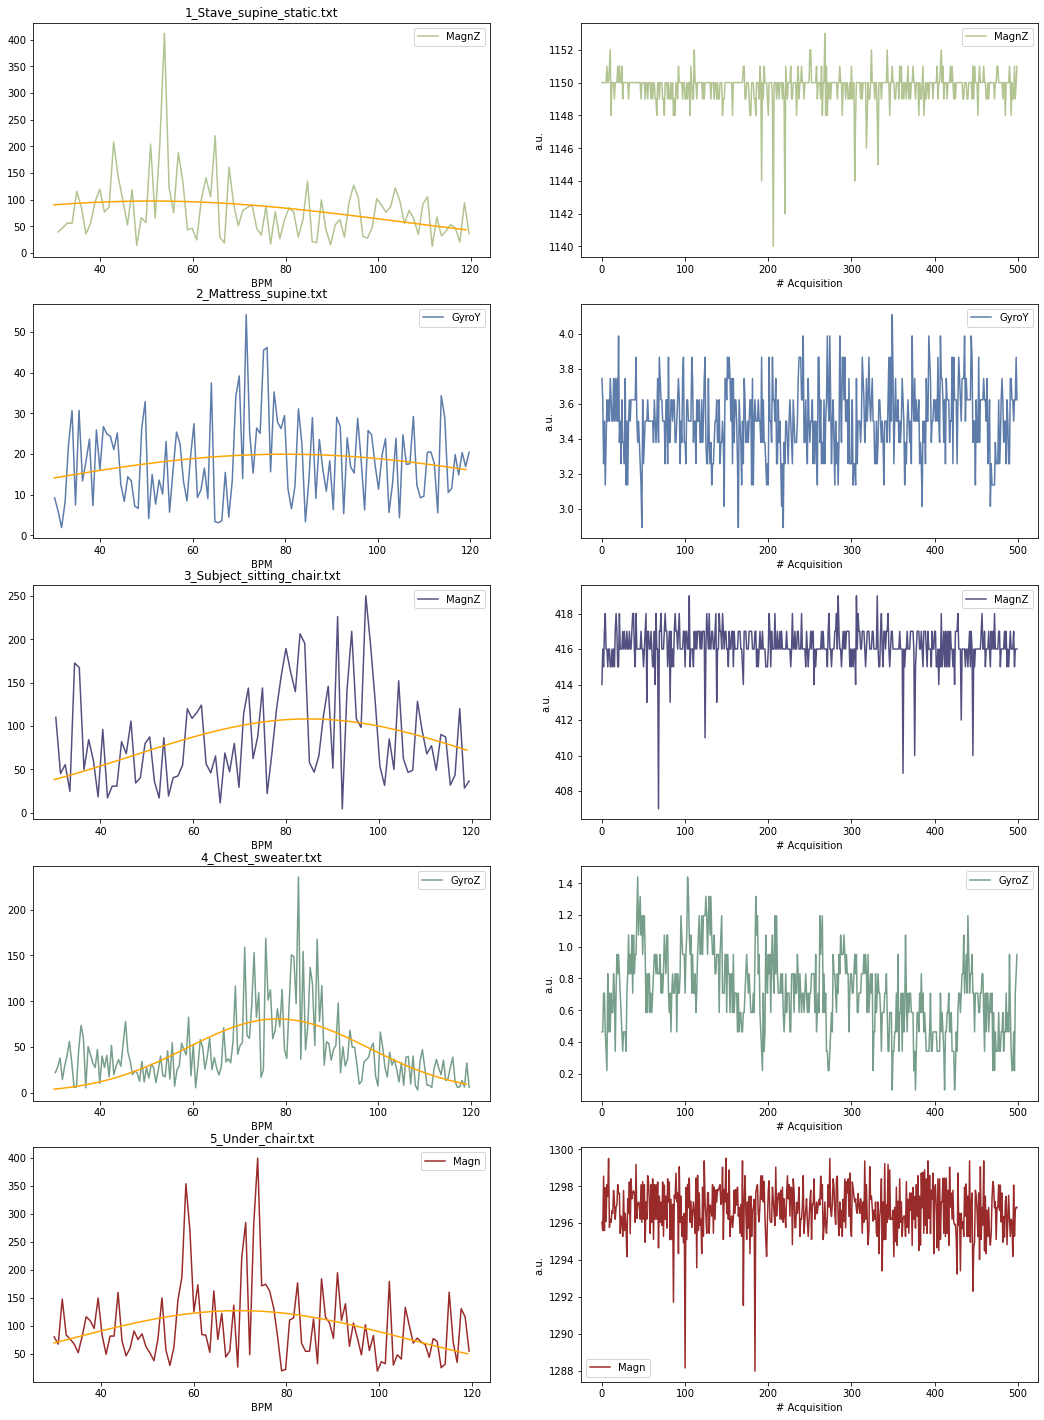

In [52]:
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(18, 25))
colori={0:"#B2C491",1:"#5D7CAA",2:"#525080",3:"#779E8A", 4:"#992b2b"}

for i in range(5):
    ax[i,0].plot(fourier_info.loc[i,"f_freq"],fourier_info.loc[i,"f_power"], color=colori[i], label=fourier_info.loc[i,"best_var"])
    ax[i,0].set_title(fourier_info.loc[i,"file"])
    ax[i,0].legend()
    ax[i,0].set_xlabel("BPM")
    x=np.arange(30,120)
    ax[i,0].plot(x,normal(x,fourier_info.loc[i,"mu"],fourier_info.loc[i,"sigma"],fourier_info.loc[i,"amp"]), color="orange")

    ax[i,1].plot(np.arange(500),best_values[i][1000:1500], color=colori[i], label=fourier_info.loc[i,"best_var"])
    ax[i,1].legend()
    ax[i,1].set_xlabel("# Acquisition")
    ax[i,1].set_ylabel("a.u.")    

### Final results and comparison
##### Center_sternum file: 
| Method | Heart bit (BPM) | Std dev (BPM) |
| --- | --- | --- |
| Gyros FT fits| 79 | 15 |
| Histo of the maximums filtered (band-pass) signal | 78 | 9 |
| Histo of the maximums filtered (band-pass + gaussian) signal | 77 | 6 |
| Threshold on Gyro | 77 | 9 |

##### Other files: 
| Position | Heart bit (BPM) | Std dev (BPM) |
| --- | --- | --- |
| Stave_supine_static | 50 | 53 |
| Mattress_supine | 80 | 60 |
| Subject_sitting_chair | 85 | 38 |
| Chest_sweater | 78 | 20 |
| Under_chair | 70 | 36 |

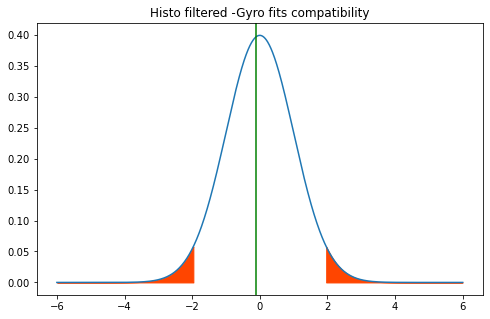

In [53]:
fig, ax = plt.subplots(figsize=(8, 5))
t= (77-79)/m.sqrt(15**2+6**2)

x = np.linspace(-6, +6, 1000)
y = stats.norm.pdf(x)
x_cl1=x[x<-1.96]
x_cl2=x[x>1.96]

ax.plot(x, y, label="Gaussian dist")
ax.axvline(t,  color='green', label="t value")
ax.fill_between(x_cl1, stats.norm.pdf(x_cl1,0, 1),color='orangered')
ax.fill_between(x_cl2, stats.norm.pdf(x_cl2,0, 1),color='orangered', label="Rejection region") 

ax.set_title("Histo filtered -Gyro fits compatibility")

plt.show()